# Introduction
As a new English teacher, I'm curious about the overall ESL market in Spain.  Specifically:
* **Offered price.** Which regions have the highest and lowest price offerings?  Do ratings matter?  How does teacher price compare to cost of living? 
* **Teacher demand**. Are there certain areas where teachers are under or over-represented based on population and does this affect the offered price?
* **Native vs. non-native instructors.** What is the breakdown between native and non-native English speakers and is there a difference in asking price?
* **Reviews.** Do reviews affect the price and what percentage of teachers have reviews?
* **Paid advertising.** What percentage of teachers pay for advertising on the site and does it give a discernable advantage?
* **Search results.** Who is at the top? Does the algorithm favor teachers with reviews, paying customers, new teachers, teachers with a photo….?

In [37]:
#Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from IPython.display import display, HTML
import re
from bs4 import BeautifulSoup
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
print("Packages loaded")

Packages loaded


# Load and Clean Data
Perform the following data cleaning tasks.
* Import raw CSV that we created in scraping portion.
* Extract ad_id from URL
* De_dupe ad_id and set to index
* Calculate rank (order of search results)
* Parse out pricing details from raw price text field
* Use ad_status to parse out gender
* Extra column to check if teacher has reviews.
* Paid advertising boolean - is it a paid listing?




In [38]:
#read raw data
scraped_profiles = pd.read_csv('tus_clases_scraped_profiles.csv')

#Create ad_id as unique identifier
#looking for at least 3 digit number, everything in a row, if there are multiple instances, take the last
scraped_profiles['ad_id'] = scraped_profiles.apply(lambda x: re.findall(r'([0-9]{3,})', x['url'])[-1], axis=1)

#duplicates check - which records are duplicated and why?
dupes_mask_ad_id = scraped_profiles.duplicated(['ad_id'], keep=False)
scraped_profiles[dupes_mask_ad_id].sort_values(by='ad_id').head()

,url,ad_title,teaching_subject,province,class_level_para,class_level_niveles,method,price,teacher_name,rating_count,...,results_ad_status,has_picture,results_page_url,alternative_scraping,teacher_has_profile_page,is_academy,html,date_scraped,base_region,ad_id
50640,https://www.tusclasesparticulares.com/domicilio/madrid/clases-particulares-ingles-espanol-estranjeros-1003894,Clases particulares de Inglés distintos niveles,Inglés,"Alcalá De Henares, Sevilla Capital (Madrid)",Todos los niveles,Todos los niveles,"A domicilio, en empresas",Precio:12 €/h Primera clase gratis,Talía,0,...,trr aitem int,True,https://www.tusclasesparticulares.com/profesores-ingles/madrid.aspx?pagina=176,False,True,False,<http.client.HTTPResponse object at 0x1a28fe9250>,2020-01-14 13:10:25.004238+00:00,madrid,1003894
28795,https://www.tusclasesparticulares.com/domicilio/madrid/clases-particulares-ingles-espanol-estranjeros-1003894,Clases particulares de Inglés distintos niveles,Inglés,"Alcalá De Henares, Sevilla Capital (Madrid)",Todos los niveles,Todos los niveles,"A domicilio, en empresas",Precio:12 €/h Primera clase gratis,Talía,0,...,trr aitem int,True,https://www.tusclasesparticulares.com/profesores-ingles/sevilla.aspx?pagina=21,False,True,False,<http.client.HTTPResponse object at 0x1a24158510>,2019-12-25 02:48:34.094673+00:00,sevilla,1003894
44847,https://www.tusclasesparticulares.com/profesores/alava/professora-ingles-nativo-irlanda-vitoria-gasteiz-1004485,Professora de ingles nativo de Irlanda,Inglés,"Vitoria Gasteiz, Barcelona Capital (Araba)",Todos los niveles,Todos los niveles,"A domicilio, en empresas",Precio:15 €/h Primera clase gratis,Loyola,0,...,trr aitem int,True,https://www.tusclasesparticulares.com/profesores-ingles/barcelona.aspx?pagina=387,False,True,False,<http.client.HTTPResponse object at 0x1a2c070a50>,2020-01-13 08:10:05.161837+00:00,barcelona,1004485
15445,https://www.tusclasesparticulares.com/profesores/alava/professora-ingles-nativo-irlanda-vitoria-gasteiz-1004485,Professora de ingles nativo de Irlanda,Inglés,"Vitoria Gasteiz, Barcelona Capital (Araba)",Todos los niveles,Todos los niveles,"A domicilio, en empresas",Precio:15 €/h Primera clase gratis,Loyola,0,...,trr aitem int,True,https://www.tusclasesparticulares.com/profesores-ingles/vitoria.aspx?pagina=18,False,True,False,<http.client.HTTPResponse object at 0x1a1de3f650>,2019-12-20 08:00:25.811235+00:00,vitoria,1004485
15199,https://www.tusclasesparticulares.com/profesores-ingles/profesora-nativa-tres-cantos-tres-cantos-100563.aspx,Profesora nativa en Vitoria-Gasteiz y zona norte,Inglés,"Tres Cantos, Vitoria-Gasteiz (Madrid)","E.S.O., Bachillerato, Universidad, Adultos, Empresas",Todos los niveles,"Presenciales (en casa del profesor), a domicilio, en empresas",Precio:28 €/h Primera clase gratis,Sonya,17,...,trr aitem plus int,True,https://www.tusclasesparticulares.com/profesores-ingles/vitoria.aspx?pagina=6,False,True,False,<http.client.HTTPResponse object at 0x1a1eebd690>,2019-12-20 08:00:25.811235+00:00,vitoria,100563


* Seeing about 1800 dupes out of 57,000.  3% dupes.  Mostly due to profesors changing reasons as well as buggy location data with tusclases.  
* Strange edge cases: https://www.tusclasesparticulares.com/domicilio/madrid/clases-particulares-ingles-espanol-estranjeros-1003894 Gives classes in "sevilla capital (madrid)"
* Barcelona Capital (Araba) https://www.tusclasesparticulares.com/profesores/alava/professora-ingles-nativo-irlanda-vitoria-gasteiz-1004485 

In [39]:
#let's further dig into the duplicates and examine records that are repeated more than twice
scraped_profiles[scraped_profiles.groupby('ad_id')['ad_id'].transform('size') > 2].sort_values(by='ad_id').head(5)

,url,ad_title,teaching_subject,province,class_level_para,class_level_niveles,method,price,teacher_name,rating_count,...,results_ad_status,has_picture,results_page_url,alternative_scraping,teacher_has_profile_page,is_academy,html,date_scraped,base_region,ad_id
35415,https://www.tusclasesparticulares.com/profesores/valencia/yes-you-canspeak-english-valencia-capital-1051419,"Yes, you can...speak English!",Inglés,Valencia Capital (Valencia),"Universidad, Adultos, Empresas",Todos los niveles,"A domicilio, en empresas",Precio:20 €/h Primera clase gratis,Jude,5,...,trr aitem int,True,https://www.tusclasesparticulares.com/profesores-ingles/valencia.aspx?pagina=176,False,True,False,<http.client.HTTPResponse object at 0x1a26415790>,2020-01-05 22:28:58.417152+00:00,valencia,1051419
35410,https://www.tusclasesparticulares.com/profesores/valencia/yes-you-canspeak-english-valencia-capital-1051419,"Yes, you can...speak English!",Inglés,Valencia Capital (Valencia),"Universidad, Adultos, Empresas",Todos los niveles,"A domicilio, en empresas",Precio:20 €/h Primera clase gratis,Jude,5,...,trr aitem int,True,https://www.tusclasesparticulares.com/profesores-ingles/valencia.aspx?pagina=176,False,True,False,<http.client.HTTPResponse object at 0x1a230f9f90>,2020-01-05 22:28:58.417152+00:00,valencia,1051419
35414,https://www.tusclasesparticulares.com/profesores/valencia/yes-you-canspeak-english-valencia-capital-1051419,"Yes, you can...speak English!",Inglés,Valencia Capital (Valencia),"Universidad, Adultos, Empresas",Todos los niveles,"A domicilio, en empresas",Precio:20 €/h Primera clase gratis,Jude,5,...,trr aitem int,True,https://www.tusclasesparticulares.com/profesores-ingles/valencia.aspx?pagina=176,False,True,False,<http.client.HTTPResponse object at 0x1a2646fc50>,2020-01-05 22:28:58.417152+00:00,valencia,1051419
35412,https://www.tusclasesparticulares.com/profesores/valencia/yes-you-canspeak-english-valencia-capital-1051419,"Yes, you can...speak English!",Inglés,Valencia Capital (Valencia),"Universidad, Adultos, Empresas",Todos los niveles,"A domicilio, en empresas",Precio:20 €/h Primera clase gratis,Jude,5,...,trr aitem int,True,https://www.tusclasesparticulares.com/profesores-ingles/valencia.aspx?pagina=176,False,True,False,<http.client.HTTPResponse object at 0x1a2406e250>,2020-01-05 22:28:58.417152+00:00,valencia,1051419
36242,https://www.tusclasesparticulares.com/profesores/albacete/profesora-lengua-sintaxis-tecnicas-estudio-1067998,"Profesora de lengua, Sintaxis y Técnicas de Estudio",Bachillerato,"Caudete, Almansa, Biar, La Font De La Figuera... (Albacete)",Todos los niveles,EMPTY,EMPTY,Precio:12 €/h Primera clase gratis,Asunción,1,...,trr aitem int,True,https://www.tusclasesparticulares.com/profesores-ingles/valencia.aspx?pagina=218,False,True,False,<http.client.HTTPResponse object at 0x1a27d7b250>,2020-01-05 22:28:58.417152+00:00,valencia,1067998


Small amount of records, duplicates can be attributed to tusclase location issues and accidental webscraping repeats.  Let's drop duplicates, leaving most recent record.

In [40]:
#drop dupes
print('reords before drop: ' + str(scraped_profiles.shape[0]))
scraped_profiles_dropped = scraped_profiles.sort_values('date_scraped').drop_duplicates('ad_id',keep='last').set_index('ad_id')
print('reords after drop: ' + str(scraped_profiles_dropped.shape[0]))


reords before drop: 57123
reords after drop: 56226


In [41]:
#Calculate rank (order of search results)
def results_ranking(row):
    pattern= "[0-9]{1,3}$"
    url = row['results_page_url']
    if re.search(pattern, url):
        results_page_pagination_number = int(re.search(pattern, url).group())
    else:
        results_page_pagination_number = 1
    
    if results_page_pagination_number == 1:
        overall_rank = row['page_rank']
    else:
        overall_rank = ((results_page_pagination_number - 1) * 20) + row['page_rank']
    return pd.Series([results_page_pagination_number, overall_rank])

scraped_profiles_dropped[['results_page_pagination_number', 'overall_rank']] = scraped_profiles_dropped.apply(lambda x: results_ranking(x), axis=1)
scraped_profiles_dropped[['results_page_url', 'page_rank','results_page_pagination_number', 'overall_rank']].tail()

,results_page_url,page_rank,results_page_pagination_number,overall_rank
ad_id,,,,
1935689,https://www.tusclasesparticulares.com/profesores-ingles/madrid.aspx?pagina=167,13,167,3333
1898557,https://www.tusclasesparticulares.com/profesores-ingles/madrid.aspx?pagina=167,14,167,3334
1195049,https://www.tusclasesparticulares.com/profesores-ingles/madrid.aspx?pagina=167,15,167,3335
289820,https://www.tusclasesparticulares.com/profesores-ingles/madrid.aspx?pagina=167,8,167,3328
1126051,https://www.tusclasesparticulares.com/profesores-ingles/madrid.aspx?pagina=500,20,500,10000


Price is a text field that has several important pieces of information:
* Base price of classes.
* Extra charge for at-home classes
* potential offer for free first class


In [42]:
print(scraped_profiles_dropped.iloc[5]['price'])

Precio:6 €/h                                                                    


In [43]:
#Let's create a function for grabbing the important information from price field  and write it out to three distinct columns
def extract_pricing_columns(price):
    if price == 'EMPTY':
        return pd.Series([np.nan, np.nan, np.nan])
    
    #get regular price
    class_price_pattern = r'[Pp]recio:([0-9]{1,})'
    match_price = re.search(class_price_pattern, price)
    if match_price:
        class_price = int(match_price.group(1))
    else:
        pdb.set_trace()
        class_price = 'scraped price but no value'
    #get domicilio charge (visiting student at home)
    domicilio_pattern = r'domicilio:\s([0-9]{1,})'
    match_dom = re.search(domicilio_pattern, price)
    if match_dom:
        domicilio_price = int(match_dom.group(1))
    else:
        domicilio_price = 0    
    
    #get first class free
    first_class_free = 'primera clase gratis' in price.lower()
    
    return pd.Series([class_price, domicilio_price, first_class_free])
        
scraped_profiles_dropped[['class_price', 'domicilio_price', 'first_class_free']] = scraped_profiles_dropped.apply(lambda x: extract_pricing_columns(x['price']), axis=1)
scraped_profiles_dropped[['url', 'price', 'class_price', 'domicilio_price', 'first_class_free']].tail(5)

,url,price,class_price,domicilio_price,first_class_free
ad_id,,,,,
1935689,https://www.tusclasesparticulares.com/profesores/madrid/clases-refuerzo-conversacion-preparacion-examenes-oficiales-ingles-1935689,EMPTY,NaN,NaN,NaN
1898557,https://www.tusclasesparticulares.com/profesores/madrid/profesora-nativa-ingles-madrid-madrid-centro-1898557,Precio:25 €/h Primera clase gratis,25.0,0.0,True
1195049,https://www.tusclasesparticulares.com/profesores/madrid/aprende-ingles-forma-divertida-profesor-nativo-1195049,Precio:15 €/h,15.0,0.0,False
289820,https://www.tusclasesparticulares.com/profesores-ingles/clases-ingles-las-rozas-majadahonda-pozuelo-289820,Precio:15 €/h (suplemento a domicilio: 5 €)Primera clase gratis,15.0,5.0,True
1126051,https://www.tusclasesparticulares.com/profesores/madrid/profesora-particular-ingles-getafe-1126051,Precio:16 €/h (suplemento a domicilio: 2 €)Primera clase gratis,16.0,2.0,True


In [44]:
#create advertising boolean - do they pay for advertising?

#results boost puts listing at front of results and addds yellow bar so that it stands out
scraped_profiles_dropped['advertising_results_boost'] = scraped_profiles_dropped['results_ad_status'].apply(lambda x: True if 'destacado' in x else False)

#adds check mark to profile and something to the affect of "verified profesor"
scraped_profiles_dropped['advertising_check_on_profile'] = scraped_profiles_dropped['results_ad_status'].apply(lambda x: True if 'plus' in x else False)

scraped_profiles_dropped[['advertising_check_on_profile', 'advertising_results_boost', 'results_ad_status']].head()


,advertising_check_on_profile,advertising_results_boost,results_ad_status
ad_id,,,
1428239,True,True,trr aitem destacado plus int hit
1777055,False,False,trr aitem int
1767666,False,False,trr aitem int
1766665,False,False,trr aitem int
1524914,False,False,trr aitem int


Looks good!

In [45]:
#how many out of total have empty price?
missing_price_count = scraped_profiles_dropped[scraped_profiles_dropped['price'] == 'EMPTY'].shape[0]
missing_price_count / scraped_profiles_dropped.shape[0] * 100

9.879770924483335

About 10% don't have a price listed.  Let's create a price boolean and do a bit of exploration.

In [49]:
#create column for price boolean
scraped_profiles_dropped['has_price'] = scraped_profiles_dropped['price'].apply(lambda x: False if x=='EMPTY' else True)

empty_price_profiles = scraped_profiles_dropped[scraped_profiles_dropped['has_price'] == False]

columns= ['url', 'price', 'teacher_has_profile_page', 'is_academy' ]

print('HAS_PROFILE for empty price')
print(empty_price_profiles[columns]['teacher_has_profile_page'].value_counts(normalize=True))
print('HAS_PROFILE for all teachers')
print(scraped_profiles_dropped[columns]['teacher_has_profile_page'].value_counts(normalize=True))

print('is_academy for empty price')
print(empty_price_profiles[columns]['is_academy'].value_counts(normalize=True))
print('is_academy for all teachers')
print(scraped_profiles_dropped[columns]['is_academy'].value_counts(normalize=True))


HAS_PROFILE for empty price
True     0.625923
False    0.374077
Name: teacher_has_profile_page, dtype: float64
HAS_PROFILE for all teachers
True     0.834614
False    0.165386
Name: teacher_has_profile_page, dtype: float64
is_academy for empty price
False    0.863546
True     0.136454
Name: is_academy, dtype: float64
is_academy for all teachers
False    0.979387
True     0.020613
Name: is_academy, dtype: float64


63% of missing price teachers have profile page.  
83% of overall teachers have profile page

Supports hypothesis that lack of price is due to an old profile.

13% of missing price teachers are academy.
2% of overall.  

Empty price is due to being academy or outdated ad (with lack of teacher profile and no teacher picture).  Tricky to know for sure because it's been impossible to reproduce - created new profile and ad with no price and was automatically set to 6.



Teachers with missing price, where are they in search results?


HAS_PROFILE for all teachers
True     0.834614
False    0.165386
Name: teacher_has_profile_page, dtype: float64


Text(0.5, 1.0, 'Results Rank for Ads based on presence of price')

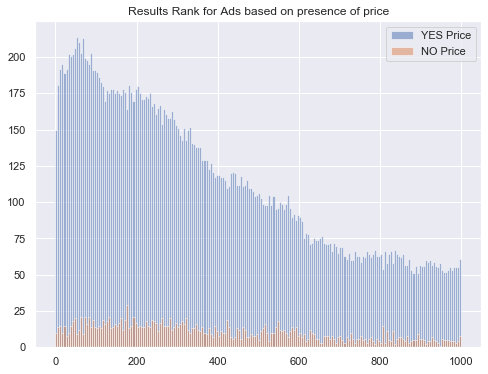

In [36]:
#page rank of teachers with no profile?  Hypothesis, they are all at the end because they're outdated or expired.
columns= ['url','teacher_has_profile_page', 'is_academy', 'overall_rank' ]

print('HAS_PROFILE for all teachers')
print(scraped_profiles_dropped[columns]['teacher_has_profile_page'].value_counts(normalize=True))

#filter for no profile page, visualize page rank
no_profile_mask = scraped_profiles_dropped['teacher_has_profile_page'] == False
no_academy_mask = scraped_profiles_dropped.is_academy == False


#QUESTION - HISTOGRAM ON SAME PLOT, TWO DIFFERENT AXIS
#SOLUTION - Plot historgram (frequency distribution) Of ad listing placement (overall rank) cut by 
#'has profile page' and 'no profile page'.  Also examine 'has picture' / 'no picture'

#profile page
fig, ax= plt.subplots(figsize=(8, 6))
bins = 200
ax.hist(scraped_profiles_dropped['overall_rank'][(scraped_profiles_dropped['has_price'] == True) & (no_academy_mask)], bins, alpha=0.5, range=[0,1000] , label='YES Price')
ax.hist(scraped_profiles_dropped['overall_rank'][(scraped_profiles_dropped['has_price'] == False) & (no_academy_mask)], bins, alpha=0.5, range=[0,1000], label='NO Price')
ax.legend(loc='upper right')
ax.set_title('Results Rank for Ads based on presence of price')


How is it that there are teachers with no price at the top of the results?  Academies?  Newly created profiles? (but how would there be no price, seems impossible to have no price)?  Below shows that very few of these cases use advertising.  Strange, but let's move on.

In [17]:
#**Gender** Use ad_status to parse out gender.  We need to use the name of the profe_ad_status.  
#10% of teachers pay for advertising or are deemed special teachers by TusClases and are given a "profe status".  
#Due to Spanish being a gendered language.

ad_status_value_counts = pd.DataFrame(scraped_profiles_dropped.profe_ad_status.value_counts(normalize=True) * 100)
display(HTML(ad_status_value_counts.to_html()))

,profe_ad_status
EMPTY,89.289652
Profesora verificada,2.865222
Profesora inscrita en el programa de confianza,2.091559
Profesor Verificado,1.853235
Profesor inscrito en el Programa de Confianza,1.552662
Centro Verificado,0.821684
Profesora plus,0.615374
Profesor plus,0.478426
Profesora estrella,0.225874
Profesor estrella,0.140504


We can parse out gender for the 10% of teachers that have an profe_ad_status.  90% of the teachers have no ad status and thus we don't know the gender.  

In [376]:
#parse out gender
scraped_profiles_dropped['gender'] = scraped_profiles_dropped['profe_ad_status'].apply(lambda x: np.nan if x=='EMPTY' else ('male' if 'Profesor ' in x else 'female'))

#scraped_profiles_filtered[['profe_ad_status', 'gender']].tail(20)
scraped_profiles_dropped.gender.value_counts(normalize=True) * 100


female    62.421123
male      37.578877
Name: gender, dtype: float64

Slightly weighted toward female teachers.  62 / 48 split.

In [377]:
#add column to check if teacher has reviews.
scraped_profiles_dropped['has_rating'] = scraped_profiles_dropped['rating_count'].apply(lambda x: True if x>0 else False)

# Pre-Filtering

Before analyzing, let's further cull the data.  
* Non-private teacher (academy)
* Irregular prices (higher than 50)
* no profile page, no price, no picture - only authentic teachers

In [379]:
#FILTERS - Only look at private teachers
filter_mask = (scraped_profiles_dropped.is_academy == False)
print('filtering out x teachers for being academy:')
print(scraped_profiles_dropped[~filter_mask]['url'].count())
print('out of x TOTAL teachers:')
print(scraped_profiles_dropped['url'].count())
scraped_profiles_filtered = scraped_profiles_dropped[filter_mask]

filtering out x teachers for being academy:
1159
out of x TOTAL teachers:
56226


In [380]:
#based on subsequent price analysis and common knowledge, ad listings with prices above 50 should be disregarded
#as bad data, error and inadmissable.  36 records are thrown out.

less_than_50_mask = (scraped_profiles_filtered.class_price > 50) & (scraped_profiles_filtered.price != 'EMPTY') 

print('filtering out x teachers for price:')
print(scraped_profiles_filtered[less_than_50_mask][['url', 'price','class_price']].count())

print('out of x TOTAL teachers:')
print(scraped_profiles_dropped['url'].count())

scraped_profiles_filtered = scraped_profiles_filtered[~less_than_50_mask]

filtering out x teachers for price:
url            36
price          36
class_price    36
dtype: int64
out of x TOTAL teachers:
56226


Should no profile page and empty picture be grounds for filtering out?

HAS_PROFILE for all teachers
True     0.831168
False    0.168832
Name: teacher_has_profile_page, dtype: float64


Text(0.5, 1.0, 'Results Rank for Ads based on presence of teacher profile')

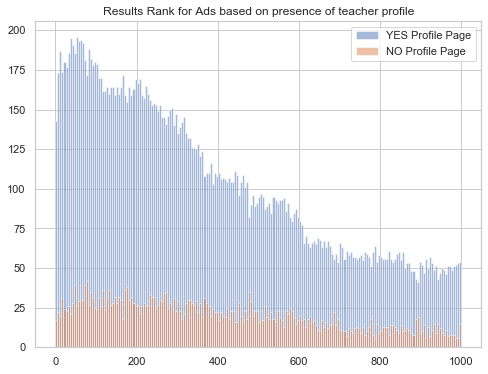

In [382]:
#page rank of teachers with no profile?  Hypothesis, they are all at the end because they're outdated or expired.
columns= ['url','teacher_has_profile_page', 'has_picture', 'is_academy', 'overall_rank' ]

print('HAS_PROFILE for all teachers')
print(scraped_profiles_filtered[columns]['teacher_has_profile_page'].value_counts(normalize=True))

#filter for no profile page, visualize page rank
no_profile_mask = scraped_profiles_filtered['teacher_has_profile_page'] == False

#profile page
fig, ax= plt.subplots(figsize=(8, 6))
bins = 200
ax.hist(scraped_profiles_filtered['overall_rank'][scraped_profiles_filtered['teacher_has_profile_page'] == True], bins, alpha=0.5, range=[0,1000] , label='YES Profile Page')
ax.hist(scraped_profiles_filtered['overall_rank'][scraped_profiles_filtered['teacher_has_profile_page'] == False], bins, alpha=0.5, range=[0,1000], label='NO Profile Page')
ax.legend(loc='upper right')
ax.set_title('Results Rank for Ads based on presence of teacher profile')


We are seeing that teachers with no profile page are less common yet somewhat evenly distributed across search results.  

has_picture for all teachers
True     0.798223
False    0.201777
Name: has_picture, dtype: float64


Text(0.5, 1.0, 'Results Rank for Ads based on presence of Picture')

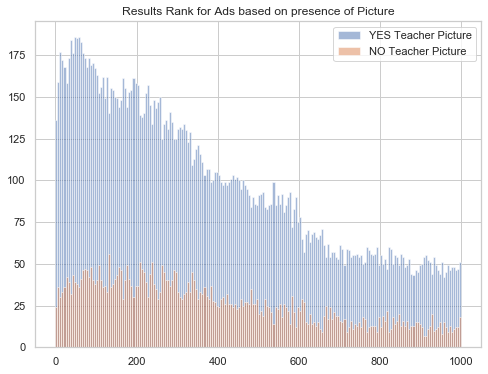

In [383]:
#has picture
print('has_picture for all teachers')
print(scraped_profiles_filtered[columns]['has_picture'].value_counts(normalize=True))

fig, ax= plt.subplots(figsize=(8, 6))
bins = 200
ax.hist(scraped_profiles_filtered['overall_rank'][scraped_profiles_filtered['has_picture'] == True], bins, alpha=0.5, range=[0,1000], label='YES Teacher Picture')
ax.hist(scraped_profiles_filtered['overall_rank'][scraped_profiles_filtered['has_picture'] == False], bins, alpha=0.5, range=[0,1000],  label='NO Teacher Picture')
ax.legend(loc='upper right')
ax.set_title('Results Rank for Ads based on presence of Picture')


* Interesting, what these two graphs show is that as results rank increases, there is a higher concentration of profiles with picture and profile page.  This makes sense.  TusClases is incentivized to give preference to relevant results (picture/profile page) and thus higher ranking.
* It is odd that there is still a significant amount of teachers with no picture and no profile high in the results.  This could be due to a new teacher quickly creating an add without bothering to add a photo or make profile page (this is possible based on tests). 
* This analysis strives to look at serious teachers only; teachers that would receive contacts from interested customers.  It stands to logic that potential customers would not reach out to teachers with no pricture, no profile page and no price.  So let's create a special column "complete teacher" and filter for only those teachers.  


In [424]:
# add native column - mention of being a native teacher 
def native_parse(row):
    #look for native or nativo
    try:
        native_pattern = r'nativ[eo]'
        match_native = re.search(native_pattern, row['description'], flags=re.IGNORECASE)
        if match_native:
            is_native = True
            #add column for 'native_mention_text' which shows words before and after native to catch false positives
            capture_pattern = r"([\w\d\s,]*nativ[eo]s?[\w\d\s,]*)"
            native_mention_text = re.search(capture_pattern,  row['description'], flags=re.IGNORECASE).groups(0)        
        else:
            is_native = False
            native_mention_text = np.nan
        
        return pd.Series([is_native, native_mention_text])
    except TypeError:
        return pd.Series([np.nan, np.nan])
        #pdb.set_trace()
    
scraped_profiles_filtered[['is_native','native_mention_text']] = scraped_profiles_filtered.apply(lambda x: native_parse(x), axis=1)


In [434]:
scraped_profiles_filtered[['is_native','native_mention_text', 'description', 'url']][scraped_profiles_filtered.is_native==True].tail()


,is_native,native_mention_text,description,url
ad_id,,,,
447919,True,"(Hola, me llamo TJ y soy profesor de inglés nativo y con certificado,)","Hola, me llamo TJ y soy profesor de inglés nativo y con certificado. Tengo experiencia dando clases desde 2014. Doy clases por teléfono o Skype (y seamos honestos, se podría hacer llamando por WhatsApp).Una clase es de 25 minutos, 24 horas antes recibirás deberes que, en forma de conversación, revisamos durante la misma clase. Recibirás feedback tanto oral como por correo después de la clase.Una clase por teléfono es intensivo ya que te tienes que concentrar completamente en escuchar porque que no hay comunicación non-verbal y en mi experiencia son muy eficaces para el aprendizaje del idioma.",https://www.tusclasesparticulares.com/domicilio/madrid/clases-particulares-madrid-noreste-madrid-447919
1935521,True,"(i am highly experience british native etc,)",i am highly experience british native etc,https://www.tusclasesparticulares.com/profesores/madrid/check-what-you-teach-madrid-centro-1935521
1935374,True,"(I am a native born English speaker and a graduate of Communication Arts and a taking up my Masters in Education,)",I am a native born English speaker and a graduate of Communication Arts and a taking up my Masters in Education. I also have completed a one month TESOL certificate course. I can offer English conversation classes and English grammar classes to all ages . Currently I teach English at a school to young adults ages 17 to 24. Available schedule are Wednesday and Thursday late afternoons and Fridays early afternoon til 6 pm. My style is casual and student centered. I aim to design the learning time to cover English around the interest of the student . My aim to is to help the student express himself and remain motivated.,https://www.tusclasesparticulares.com/profesores/madrid/english-conversation-and-grammar-classes-1935374
1552233,True,"( Profesor especializado nativo ,)","➔ Profesor especializado nativo ( Londres U.K. ) Más de quince años de experiencia docente en la comunidad de Madrid.➔ EDAD :42 AÑOS.➔ Colaborando con diversas Empresas Nacionales e Internacionales, Dos Escuelas de Negocios así como con clientes particulares en la Comunidad de Madrid.➔ CLIENTES :ICADE, Rothschild & Co, Accenture, El Instituto de Empresa, BBVA, Banco Santander, Price-Waterhouse-Coopers, Uría y Menéndez o Lazard Asesores Financieros, son tan sólo algunos de las muchas entidades con las que colaboro o he colaborado en los últimos años (Referencias Disponibles).➔ ESPECIALIZACIÓN :Especializado desde hace más de diez años en Business, Financial & Legal English y en la preparación de los exámenes IELTS,TOEFL y KET, PET, FCE, CAE, CPE de la Universidad de Cambridge.➔ TARIFAEsta página pone por defecto, y sin la autorización de los profesores que en ella se anuncian, la tarifa de 6€/hora. Lógicamente, no es el precio real, que variará en función de la localización de las clases y número de clases semanales.Si estás interesado/a ponte en contacto en indicándome :● Zona de Madrid ● Disponibilidad Te enviaré hoy mismo un presupuesto totalmente personalizado, junto con mi disponibilidad para una primera entrevista informativa sin coste ni compromiso.",https://www.tusclasesparticulares.com/profesores/madrid/-business-english-vocabulario-fluidez-comprension-speaking-english-1552233
1195049,True,"(Aprende inglés de forma divertida con profesor nativo,)",Aprende inglés de forma divertida con profesor nativo,https://www.tusclasesparticulares.com/profesores/madrid/aprende-ingles-forma-divertida-profesor-nativo-1195049


In [668]:
scraped_profiles_filtered['is_native'].value_counts(normalize=True)

False    0.928449
True     0.071551
Name: is_native, dtype: float64

False positives exist but based on quick review they are not too common.  This will suffice as a general proxy.  

In [435]:
#create column - complete_teacher == teacher_has_profile_page, has_picture, has_price
columns= ['url','teacher_has_profile_page', 'has_picture', 'has_price', 'complete_teacher' ]


def complete_teacher(row):
    if row['teacher_has_profile_page'] is True and row['has_picture'] is True and row['has_price'] is True:
        return True
    else:
        return False
    

scraped_profiles_filtered['complete_teacher'] = scraped_profiles_filtered.apply(lambda x: complete_teacher(x),axis=1)
scraped_profiles_filtered[columns].head()

print('complete_teacher for all teachers')
print(scraped_profiles_filtered['complete_teacher'].value_counts(normalize=True))

complete_teacher for all teachers
True     0.677164
False    0.322836
Name: complete_teacher, dtype: float64


In [436]:
complete_teacher_mask = scraped_profiles_filtered['complete_teacher'] == True

print('filtering out x teachers for lack of profile, picture and price:')
print(scraped_profiles_filtered[~complete_teacher_mask]['url'].count())

print('out of x TOTAL teachers:')
print(scraped_profiles_filtered['url'].count())

scraped_profiles_complete_teacher = scraped_profiles_filtered[complete_teacher_mask]

print('this many teacher remain:')
print(scraped_profiles_complete_teacher.url.count())

filtering out x teachers for lack of profile, picture and price:
17766
out of x TOTAL teachers:
55031
this many teacher remain:
37265


67% of teachers have profile page, picture and price.  Let's examine these teachers.

# Population / Geographical Distribution
* High Level cut of data - where are the teachers located?

Map base_region (capital of province) to autonomous community.

In [531]:

capital_to_community_map = {
'soria': 'castilla_y_leon',
    'segovia':'castilla_y_leon',
    'huesca':'aragon', 
    'cuenca': 'castilla_la_mancha',
    'avila':'asturias',
    'zamora' : 'castilla_y_leon',
       'ciudad_real' : 'castilla_la_mancha',
    'palencia' : 'castilla_y_leon',
    'pontevedra' : 'galicia', 
    'toledo' : 'castilla_la_mancha',
    'guadalajara' : 'castilla_la_mancha',
       'ceuta' : 'ceuta',
    'melilla' : 'melilla',
    'caceres' : 'extremadura', 
    'santiago_de_compostela':'galicia',
    'lugo':'galicia',
    'gerona': 'cataluna',
    'orense':'galicia', 
    'jaen' : 'andalucia',
    'cadiz':'andalucia',
    'leon': 'castilla_y_leon',
    'tarragona' : 'cataluna', 
    'lerida' : 'cataluna',
       'salamanca' : 'castilla_y_leon', 
    'huelva':'andalucia',
    'badajoz' : 'extremadura', 
    'logrono' : 'la_rioja',
       'castellon_de_la_plana':'valencia', 
    'santander':'cantabria',
    'albacete':'castilla_la_mancha', 
    'burgos':'castilla_y_leon',
       'san_sebastian':'pais_vasco',
    'almeria' : 'andalucia',
    'pamplona' : 'navarra',
    'tenerife':'canarias', 
    'oviedo':'asturias',
       'granada':'andalucia',
    'la_coruna' : 'galicia', 
    'vitoria' : 'pais_vasco', 
    'valladolid':'castilla_y_leon',
    'cordoba':'andalucia',
       'alicante': 'valencia',
    'bilbao':'pais_vasco',
    'las_palmas_de_gran_canaria' : 'canarias',
    'palma' : 'balears',
       'murcia': 'murcia',
    'malaga':'andalucia',
    'zaragoza':'aragon',
    'sevilla': 'andalucia', 
    'valencia': 'valencia', 
    'barcelona' : 'cataluna',
       'madrid' : 'madrid'   
}
scraped_profiles_complete_teacher['autonomous_community'] = scraped_profiles_complete_teacher['base_region'].map(capital_to_community_map)



/Users/patricknoonan/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


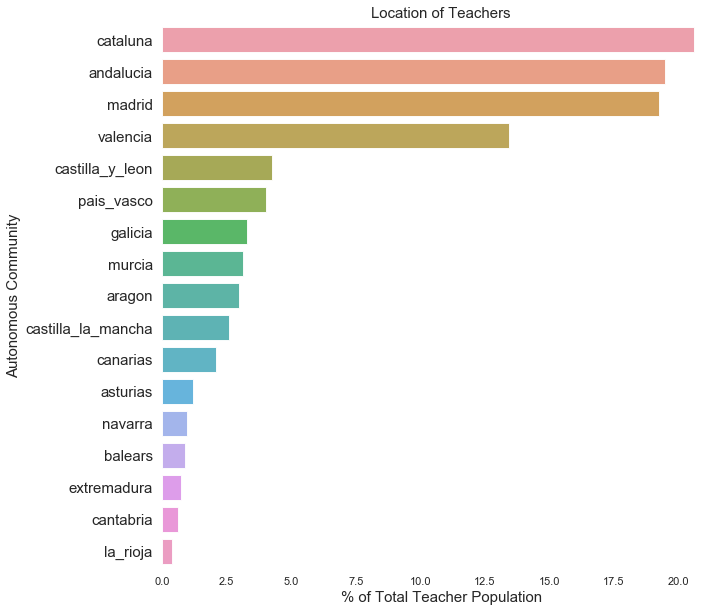

In [634]:
#FREQUENCY DISTRIBUTION USING SEABORN
from matplotlib.pyplot import figure
%matplotlib inline 

region_count = scraped_profiles_complete_teacher['autonomous_community'].value_counts(normalize=True) * 100
region_count = region_count[:-2]
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
chart = sns.barplot(y=region_count.index, x=region_count.values, alpha=0.9)
plt.title('Location of Teachers', fontsize=15)
plt.ylabel('Autonomous Community', fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('% of Total Teacher Population', fontsize=15)
plt.grid(False)

for key, spine in chart.spines.items():
    spine.set_visible(False)

plt.show()

The largest communities have the most teachers.  Makes sense.  For fun, let's group the long tail.

In [73]:
count_uniques_df = pd.DataFrame(scraped_profiles_complete_teacher['autonomous_community'].value_counts())
count_uniques_df.rename(columns={'autonomous_community':'count_uniques'}, inplace=True)
count_uniques_df['teacher_percent_total'] = scraped_profiles_complete_teacher['autonomous_community'].value_counts(normalize=True) * 100


count_uniques_df = count_uniques_df.reset_index().rename(columns={'index':'autonomous_community'})
#get top 10 regions and convert the rest into "other" bucket.  Make pie chart.  

print(count_uniques_df.head())


#get top 10 regions and create new field bucketing into long_tail or region_name(if in top 10)
top_regions = count_uniques_df.iloc[:6]['autonomous_community'].to_list()
bottom_regions = count_uniques_df.iloc[-6:]['autonomous_community'].to_list()
scraped_profiles_complete_teacher['region_bucket'] = scraped_profiles_complete_teacher.apply(lambda x: x['autonomous_community'] if x['autonomous_community'] in top_regions else 'long tail', axis=1)

  autonomous_community  count_uniques  teacher_percent_total
0  cataluna             7674           20.593050            
1  andalucia            7258           19.476721            
2  madrid               7179           19.264726            
3  valencia             5003           13.425466            
4  castilla_y_leon      1586           4.256004             


/Users/patricknoonan/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


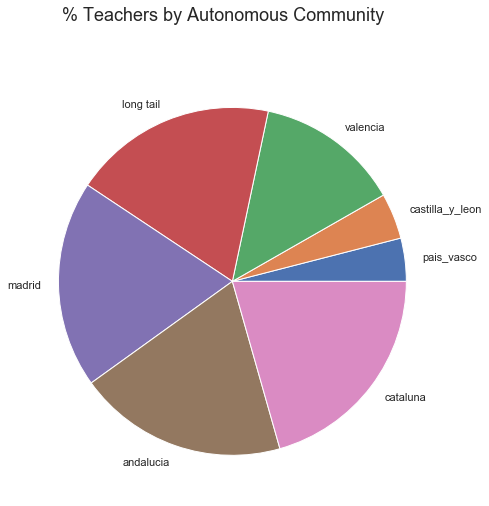

In [75]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 15.0

#create region_bucket column.  If in list of top 10, use region name, if not use 'everything else'
count_uniques_df = pd.DataFrame(scraped_profiles_complete_teacher['region_bucket'].value_counts())
count_uniques_df.rename(columns={'region_bucket':'count_uniques'}, inplace=True)
count_uniques_df['teacher_percent_total'] = scraped_profiles_complete_teacher['region_bucket'].value_counts(normalize=True) * 100

chart = count_uniques_df['teacher_percent_total'].sort_values(ascending=True).plot(kind='pie', title ="% Teachers by Autonomous Community", subplots=True, figsize=(10, 8))

plt.axis('off')
plt.show()


# Compare to external popoulation data (number of inhabitants per region)
Goal is to look for market opportunities - whre is the most demand for teachers based on current supply and demand by inhabitants. 

In [76]:
#using 'Instituto Nacional de Estadísdica' - Official Spanish Database -   https://www.ine.es/jaxiT3/Tabla.htm?t=4925&L=0
population_cleaned_df = pd.read_csv('population_cleaned_df.csv')
population_cleaned_df.head()

,Unnamed: 0,clean_capital,population
0,0,albacete,173329
1,1,alicante,334887
2,2,almeria,198533
3,3,avila,57744
4,4,badajoz,150702


In [195]:
# get count uniques by base_region 
count_uniques_base_region = pd.DataFrame(scraped_profiles_complete_teacher['base_region'].value_counts())
count_uniques_base_region.rename(columns={'base_region':'count_uniques'}, inplace=True)
count_uniques_base_region['teacher_percent_total'] = scraped_profiles['base_region'].value_counts(normalize=True) * 100
count_uniques_base_region = count_uniques_base_region.reset_index().rename(columns={'index':'base_region'})

#bring in autonomous community
count_uniques_base_region['autonomous_community'] = count_uniques_base_region['base_region'].map(capital_to_community_map)

count_uniques_base_region.head()

,base_region,count_uniques,teacher_percent_total,autonomous_community
0,madrid,7179,17.499081,madrid
1,barcelona,6862,17.506083,cataluna
2,valencia,3472,9.152180,valencia
3,sevilla,2278,6.134132,andalucia
4,malaga,1700,4.656618,andalucia


In [196]:
#merge external population data with teacher data.
merged_population_teacher_count = pd.merge(count_uniques_base_region,
                 population_cleaned_df,
                 left_on='base_region', 
                 right_on='clean_capital',
                 how='left')
merged_population_teacher_count = merged_population_teacher_count.dropna()

total_population = merged_population_teacher_count['population'].sum()
merged_population_teacher_count['percent_pop_of_total'] = merged_population_teacher_count['population'] / total_population * 100

merged_population_teacher_count.head()

,base_region,count_uniques,teacher_percent_total,autonomous_community,Unnamed: 0,clean_capital,population,percent_pop_of_total
0,madrid,7179,17.499081,madrid,26.0,madrid,3266126.0,21.815675
1,barcelona,6862,17.506083,cataluna,5.0,barcelona,1636762.0,10.932545
2,valencia,3472,9.152180,valencia,45.0,valencia,794288.0,5.305346
3,sevilla,2278,6.134132,andalucia,40.0,sevilla,688592.0,4.599363
4,malaga,1700,4.656618,andalucia,27.0,malaga,574654.0,3.838329


In [204]:
#merge in external salary data [PSN NOTE: MOVE SALARY DATA EARLIER IN NOTEBOOK] by autonomous community
salary_data.head()

merged_population_teacher_count = pd.merge(merged_population_teacher_count, salary_data, \
         left_on= 'autonomous_community', right_on='autonomous_community',\
         how='left'
        )

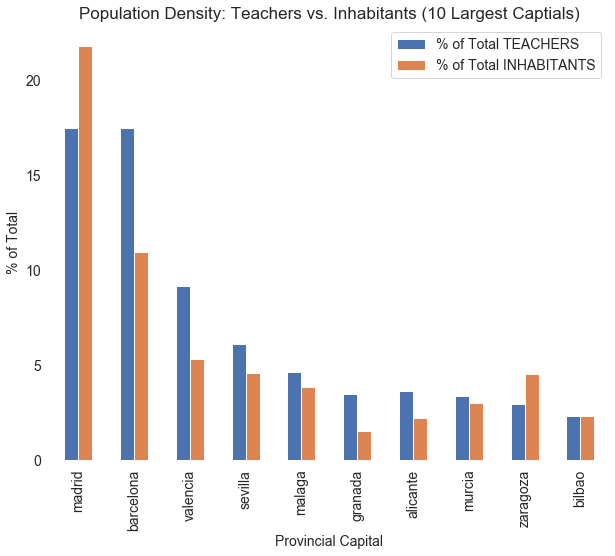

In [205]:
chart = pop_teacher_count_for_graph[:10][['teacher_percent_total', 'percent_pop_of_total']].plot(kind='bar', title ="Population Density: Teachers vs. Inhabitants (10 Largest Captials)", figsize=(10, 8), fontsize=14)
chart.title.set_size(17)
#plt.legend(prop={'size': 15})
chart.legend(["% of Total TEACHERS", "% of Total INHABITANTS"], prop={'size': 14})
chart.set_ylabel("% of Total", fontsize=14)
chart.set_xlabel("Provincial Capital", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)
chart.set_facecolor('white')
plt.show(chart)


It can be seen that there is a higher distribution of teachers in Barcelona than what one would expect based purely on population.  Said another way, About 17% of the total population of Spain is in Barcelona but only about 11% of the total Teaching population of our sample is in Barcelona.  Based on this methodology, one could argue that the teaching market in Barcelona is over-saturated (the same for Valencia, Sevilla and Granada) - this makes sense as all of those cities are highly desireable places to live for foreginers.  In contrast, Zaragoza is slightly underrepresented by English teachers - it has a higher concentration of inhabitants than concentration of English teachers.  


Let's take a different approach: look at the ratio of English Teachers to Inhabitants (by provincial Capital).  This would give us a more absolute number to work with.

In [212]:
pop_teacher_count_for_graph = merged_population_teacher_count
#[['base_region', 'population', 'count_uniques', 'percent_pop_of_total', 'teacher_percent_total']]

pop_teacher_count_for_graph['inhabitants_to_teacher_ratio'] = pop_teacher_count_for_graph.population / pop_teacher_count_for_graph.count_uniques

pop_teacher_count_for_graph.set_index('base_region', inplace=True)

all_regions_inhabitants_to_teacher_ratio = pop_teacher_count_for_graph.inhabitants_to_teacher_ratio.sort_values(ascending=False)

top_ten_inhabitants_to_teacher_ratio = pop_teacher_count_for_graph.inhabitants_to_teacher_ratio.sort_values(ascending=False)[:10]

bottom_ten_inhabitants_to_teacher_ratio = pop_teacher_count_for_graph.inhabitants_to_teacher_ratio.sort_values(ascending=True)[:10]

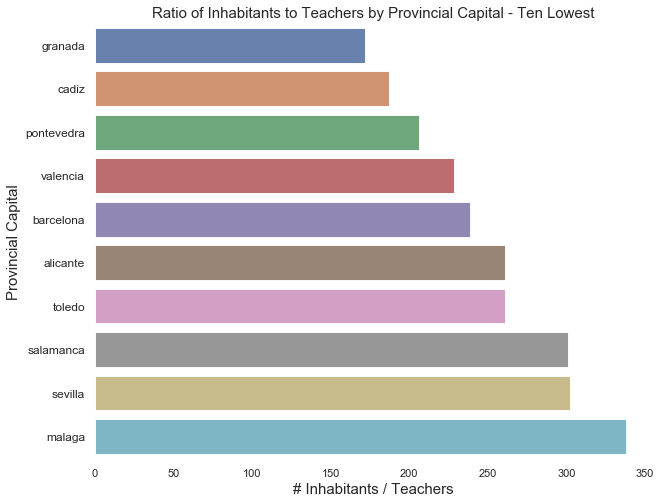

In [213]:
plt.figure(figsize=(10,8))
sns.set(style="whitegrid")
chart = sns.barplot(y=bottom_ten_inhabitants_to_teacher_ratio.index, x=bottom_ten_inhabitants_to_teacher_ratio, alpha=0.9)
plt.title('Ratio of Inhabitants to Teachers by Provincial Capital - Ten Lowest', fontsize=15)
plt.ylabel('Provincial Capital', fontsize=15)
plt.xlabel('# Inhabitants / Teachers', fontsize=15)
plt.yticks(fontsize=12)
plt.grid(False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.show()

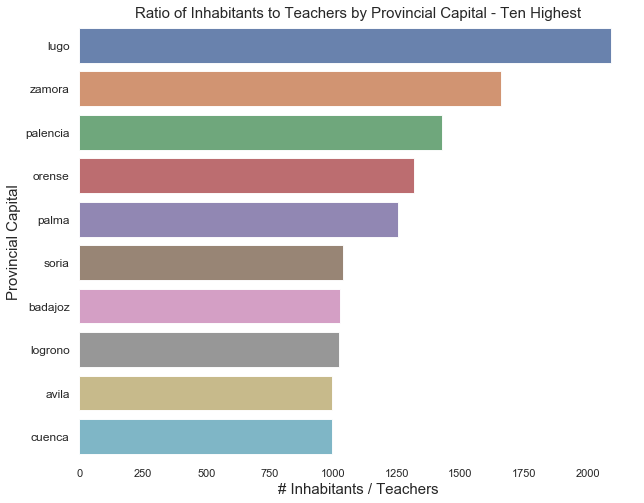

In [214]:
plt.figure(figsize=(10,8))
sns.set(style="whitegrid")
chart = sns.barplot(y=top_ten_inhabitants_to_teacher_ratio.index, x=top_ten_inhabitants_to_teacher_ratio, alpha=0.9)
plt.title('Ratio of Inhabitants to Teachers by Provincial Capital - Ten Highest', fontsize=15)
plt.ylabel('Provincial Capital', fontsize=15)
plt.xlabel('# Inhabitants / Teachers', fontsize=15)
plt.yticks(fontsize=12)

plt.grid(False)
for key, spine in chart.spines.items():
    spine.set_visible(False)

plt.show()

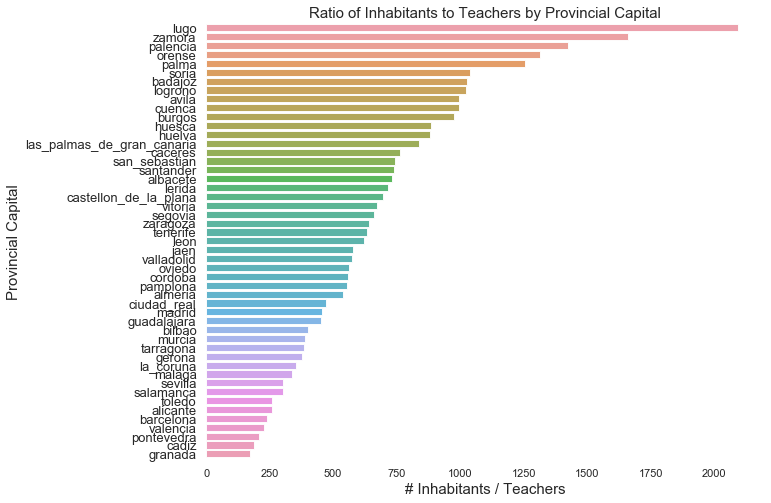

In [627]:
plt.figure(figsize=(10,8))
#sns.set(style="whitegrid")
chart = sns.barplot(y=all_regions_inhabitants_to_teacher_ratio.index, x=all_regions_inhabitants_to_teacher_ratio, alpha=0.9)
plt.title('Ratio of Inhabitants to Teachers by Provincial Capital', fontsize=15)
plt.ylabel('Provincial Capital', fontsize=15)
plt.xlabel('# Inhabitants / Teachers', fontsize=15)
plt.yticks(fontsize=13)

plt.grid(False)
for key, spine in chart.spines.items():
    spine.set_visible(False)

plt.show()

Ok.  So we have two methodolgies to compare the differences in distributions of population by region between teachers and inhabitants:
* Look at % population of teachers of total vs. % people of total, by region.  This shows us how teachers are distributed between regions in spain.  For example, say 50% of the population of spain is madrid but 90% of the population of total teachers are in madrid.  One could argue that teachers are overrepresented in madrid.  
* Look at ratio of teachers to inhabitants.  This looks at raw numbers and gives us a proxy for demand - if 90% of the teaching population is in madrid, but the ratio of inhabitants to teachers is 2000 to 1 (one of the highest) - one could argue that teachers over-represent in madrid and still have the most demand.  This number tends to look like a raw population chart.  

In [218]:
#mean price series:
mean_series = scraped_profiles_complete_teacher.groupby('base_region')['class_price'].mean()

#merge to main dataframe
pop_teacher_with_price_for_graph = pd.merge(pop_teacher_count_for_graph, mean_series, left_index=True, right_index=True, how='left')

#get difference in salary
pop_teacher_with_price_for_graph['teaching_salary_differential_to_mean'] = pop_teacher_with_price_for_graph.class_price - pop_teacher_with_price_for_graph.mean_hourly_salary
pop_teacher_with_price_for_graph.head()

,count_uniques,teacher_percent_total,autonomous_community,Unnamed: 0,clean_capital,population,percent_pop_of_total,mean_monthly_salary,mean_hourly_salary,inhabitants_to_teacher_ratio,class_price,teaching_salary_differential_to_mean
base_region,,,,,,,,,,,,
madrid,7179,17.499081,madrid,26.0,madrid,3266126.0,21.815675,2264,13.061538,454.955565,14.383619,1.322080
barcelona,6862,17.506083,cataluna,5.0,barcelona,1636762.0,10.932545,2067,11.925000,238.525503,14.208831,2.283831
valencia,3472,9.152180,valencia,45.0,valencia,794288.0,5.305346,1784,10.292308,228.769585,11.886521,1.594213
sevilla,2278,6.134132,andalucia,40.0,sevilla,688592.0,4.599363,1748,10.084615,302.279192,10.758121,0.673506
malaga,1700,4.656618,andalucia,27.0,malaga,574654.0,3.838329,1748,10.084615,338.031765,11.600588,1.515973


# Bring in salary data
See if some regions are over / under average (in terms of asking price)

In [529]:
#bring in external data of prices from this website: https://www.ine.es/jaxiT3/Tabla.htm?t=13930&L=0
salary_data = pd.read_csv('salary_data.csv', sep='\t', skiprows=6)
#filter for total salary (including part time and full time) - only looking at most recent year 2018
salary_data = salary_data.iloc[2:21,:2]
#rename columns
salary_data.rename(columns={ salary_data.columns[0]: 'autonomous_community', salary_data.columns[1]: 'mean_monthly_salary'  }, inplace = True)
#clean region
salary_data['autonomous_community'] = salary_data['autonomous_community'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.strip().str.replace(' ','_').str.replace('\d+', '').str.lower()

#fix format of salary
salary_data['mean_monthly_salary'] = salary_data['mean_monthly_salary'].str.replace("[,. ]", "").str.slice(0,4).astype(int)

#create lookup dictionary to fix names
community_lookup_dict = {
    '_andalucia': 'andalucia',
 '_aragon' : 'aragon',
 '_asturias,_principado_de' : 'asturias',
 '_balears,_illes' :'balears',
 '_canarias' : 'canarias',
 '_cantabria' : 'cantabria',
 '_castilla_y_leon' : 'castilla_y_leon',
 '_castilla_-_la_mancha' : 'castilla_la_mancha',
 '_cataluna' : 'cataluna',
 '_comunitat_valenciana' : 'valencia',
 '_extremadura' : 'extremadura',
 '_galicia' : 'galicia',
 '_madrid,_comunidad_de' : 'madrid',
 '_murcia,_region_de' : 'murcia',
 '_navarra,_comunidad_foral_de' : 'navarra',
 '_pais_vasco' : 'pais_vasco',
 '_rioja,_la' : 'la_rioja',
 '_ceuta' : 'ceuta',
 '_melilla' : 'melilla'
}

salary_data['autonomous_community'] = salary_data['autonomous_community'].map(community_lookup_dict)

salary_data['mean_hourly_salary'] = salary_data['mean_monthly_salary'] / (40 * 52/12)

salary_data.head()

,autonomous_community,mean_monthly_salary,mean_hourly_salary
2,andalucia,1748,10.084615
3,aragon,1951,11.255769
4,asturias,1977,11.405769
5,balears,1862,10.742308
6,canarias,1679,9.686538


In [532]:
# join to class data
column_grouped_on = 'autonomous_community'
chart_title ="Mean Price by autonomous_community"

price_summary = scraped_profiles_complete_teacher.groupby(by=['autonomous_community']).agg({'class_price': ['mean', 'median', 'min', 'max']})
price_summary.columns= ['mean_price', 'median_price', 'min_price', 'max_price']
price_summary.sort_values(by='mean_price', ascending=False, inplace=True)

price_summary = pd.merge(price_summary, salary_data, on='autonomous_community', how='left').set_index('autonomous_community')

#get difference between teacher rate and overall rate
price_summary['difference_teacher_to_average'] = price_summary.mean_price - price_summary.mean_hourly_salary
price_summary.sort_values(by='difference_teacher_to_average', inplace=True, ascending=False)
price_summary.head()

,mean_price,median_price,min_price,max_price,mean_monthly_salary,mean_hourly_salary,difference_teacher_to_average
autonomous_community,,,,,,,
balears,14.629518,15.0,6.0,40.0,1862,10.742308,3.887210
canarias,12.047436,12.0,5.0,50.0,1679,9.686538,2.360897
cataluna,14.053297,13.0,6.0,50.0,2067,11.925000,2.128297
cantabria,13.261803,13.0,6.0,25.0,1972,11.376923,1.884879
la_rioja,12.425676,12.0,6.0,35.0,1865,10.759615,1.666060


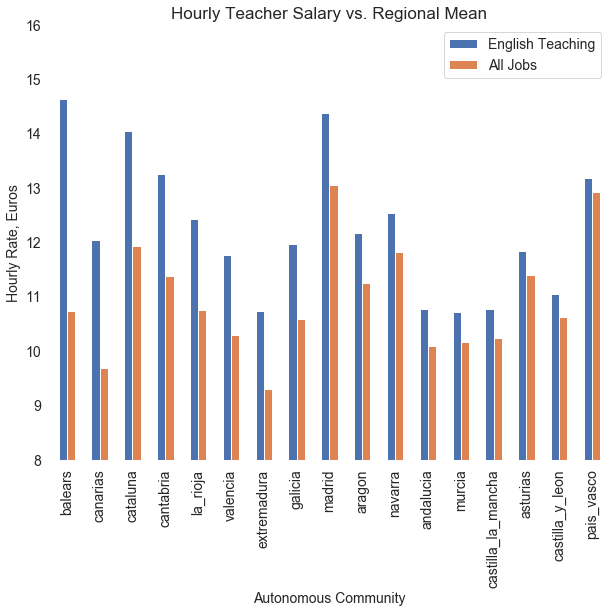

In [533]:
chart = price_summary[['mean_price','mean_hourly_salary', 'difference_teacher_to_average']].sort_values(by='difference_teacher_to_average', ascending=False).iloc[:-2,:2].plot(kind='bar', title='Hourly Teacher Salary vs. Regional Mean', figsize=(10, 8), fontsize=14)
chart.legend(["English Teaching", "All Jobs"], prop={'size': 14})
chart.title.set_size(17)
chart.set_xlabel('Autonomous Community', fontsize=14)
chart.set_ylabel("Hourly Rate, Euros", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)
chart.set_facecolor('white')
plt.ylim(8,16)
plt.show(chart)


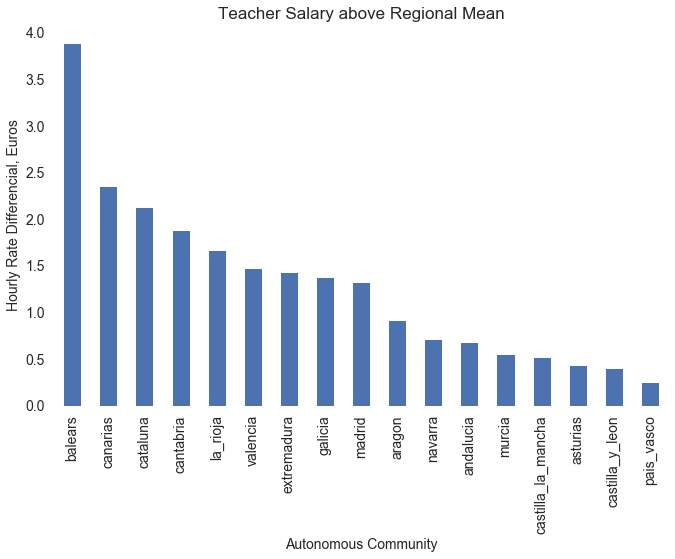

In [537]:
#JUST LOOK AT DIFFERENCE
chart = price_summary['difference_teacher_to_average'].sort_values(ascending=False).iloc[:-2].plot(kind='bar', title='Teacher Salary above Regional Mean', figsize=(11, 7), fontsize=14)
chart.title.set_size(17)
chart.set_xlabel('Autonomous Community', fontsize=14)
chart.set_ylabel("Hourly Rate Differencial, Euros", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)
chart.set_facecolor('white')
plt.show(chart)

Compare ratio of inhabitants / teachers with external salary data.

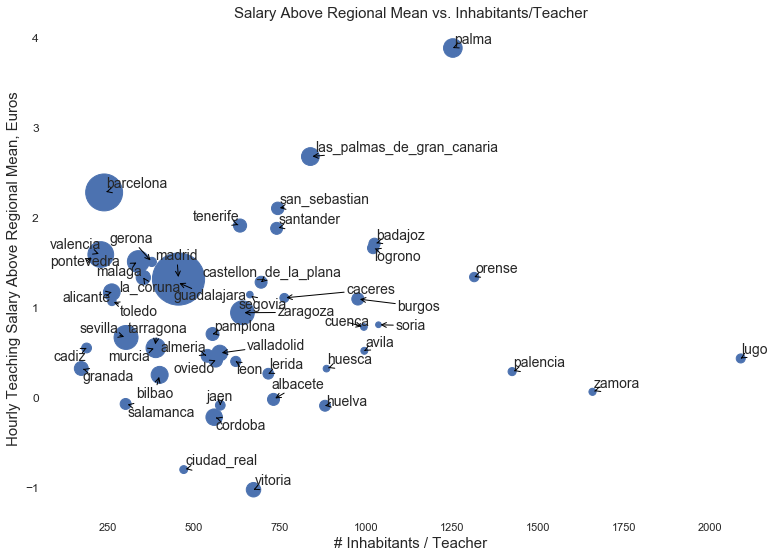

In [669]:
from adjustText import adjust_text

fig, ax = plt.subplots(figsize=(13, 9))
ax.scatter(pop_teacher_with_price_for_graph.inhabitants_to_teacher_ratio, \
            pop_teacher_with_price_for_graph.teaching_salary_differential_to_mean,
           s = pop_teacher_with_price_for_graph.population/1200)

texts = []

for i, txt in enumerate(pop_teacher_with_price_for_graph.index):
    texts.append(ax.text(pop_teacher_with_price_for_graph.inhabitants_to_teacher_ratio[i],\
                         pop_teacher_with_price_for_graph.teaching_salary_differential_to_mean[i] * 1,\
                         txt, ha='right', fontsize=14))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))

plt.title('Salary Above Regional Mean vs. Inhabitants/Teacher', fontsize=15)
plt.ylabel('Hourly Teaching Salary Above Regional Mean, Euros', fontsize=15)
plt.xlabel('# Inhabitants / Teacher', fontsize=15)
plt.yticks(fontsize=12)

plt.grid(False)
for key, spine in ax.spines.items():
    spine.set_visible(False)

plt.show()

# Offered Price Summary stats 
* Which regions have the highest and lowest price offerings? 
* Price distribution - histogram
* cut data by male / female, native / non-native, region, has reviews / no reviews, presence of picture/profile, paid advertising / unpaid advertising
* define "serious teacher" - has profile page, picture and reviews
* scatterplot correlations: number reviews/price, length of description / price, 



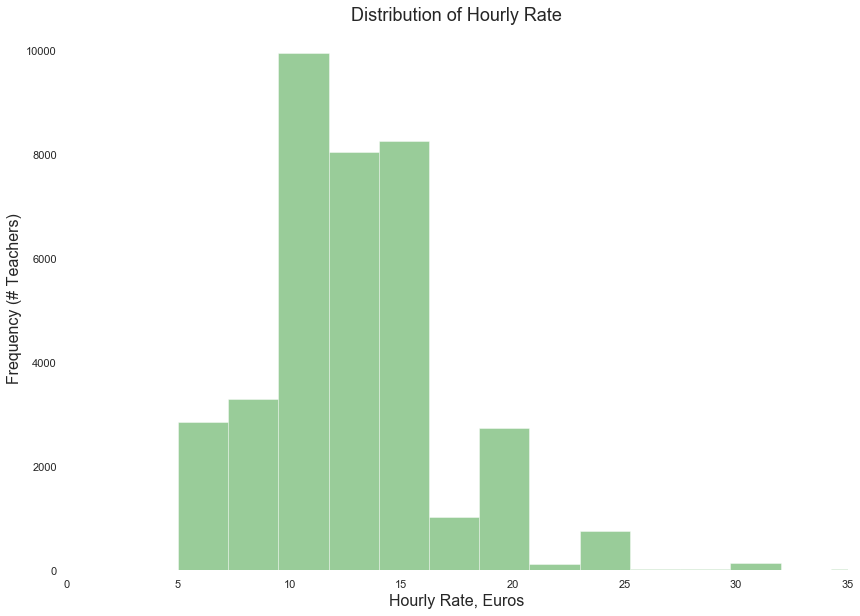

In [343]:
chart = sns.distplot(scraped_profiles_complete_teacher['class_price'], kde=False, color='green', bins=20)

plt.title('Distribution of Hourly Rate', fontsize=18)
plt.xlabel('Hourly Rate, Euros', fontsize=16)
plt.ylabel('Frequency (# Teachers)', fontsize=16)
# figure size in inches
sns.set(rc={'figure.figsize':(14,10)})

chart.set_xlim(0,35)

sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)


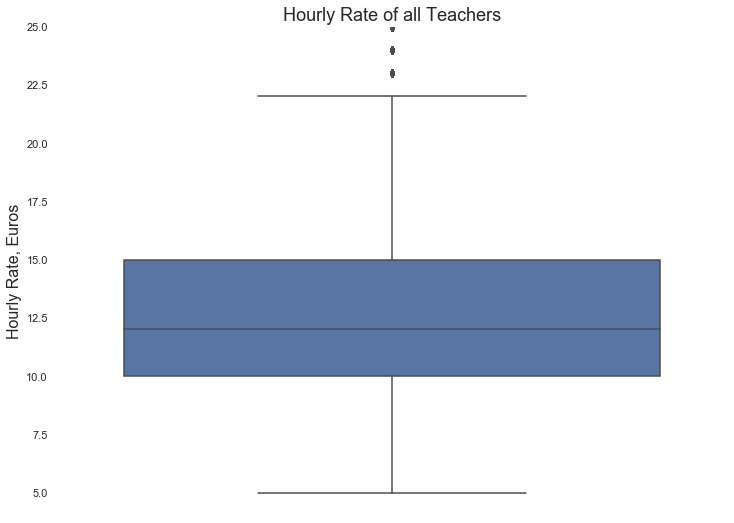

In [631]:
plt.figure(figsize=(12,9))
ax = sns.boxplot( y="class_price", data=scraped_profiles_complete_teacher)
ax.set_ylim([4,25])
plt.title('Hourly Rate of all Teachers', fontsize=18)
#plt.xlabel('# of Ratings Group', fontsize=16)
plt.ylabel('Hourly Rate, Euros', fontsize=16)
for key, spine in ax.spines.items():
    spine.set_visible(False)
plt.grid(False)

In [132]:
#basic summary stats
print(scraped_profiles_complete_teacher.agg({'class_price': ['mean', 'median', 'min', 'max']}))

        class_price
mean    12.574641  
median  12.000000  
min     5.000000   
max     50.000000  


In [359]:
#quick function to allow us to pump out summary stats on various cuts

def summary_stats_chart_price(df, column_grouped_on, chart_title, y_label, chart_type='barh'):
    price_summary = df.groupby(by=[column_grouped_on]).agg({'class_price': ['mean', 'median', 'min', 'max']})
    price_summary.columns= ['mean_price', 'median_price', 'min_price', 'max_price']
    price_summary.sort_values(by='mean_price', ascending=False, inplace=True)
    print(price_summary)

    chart = price_summary['mean_price'].sort_values().plot(kind=chart_type, title=chart_title, figsize=(13, 11), fontsize=14)
    chart.title.set_size(17)
    chart.set_xlabel("Hourly Rate, Euros", fontsize=14)
    chart.set_ylabel(y_label, fontsize=14)
    chart.tick_params(bottom=False, left=False, top=False, right=False)
    for key, spine in chart.spines.items():
        spine.set_visible(False)
    plt.grid(False)
    plt.show(chart)

                            mean_price  median_price  min_price  max_price
base_region                                                               
san_sebastian               15.035714   15.0          6.0        30.0     
palma                       14.629518   15.0          6.0        40.0     
madrid                      14.383619   15.0          6.0        50.0     
barcelona                   14.208831   14.0          6.0        50.0     
gerona                      13.437037   12.0          6.0        30.0     
santander                   13.261803   13.0          6.0        25.0     
bilbao                      13.186851   12.0          6.0        40.0     
pamplona                    12.532967   12.0          6.0        27.0     
tarragona                   12.500000   12.0          6.0        25.0     
logrono                     12.425676   12.0          6.0        35.0     
las_palmas_de_gran_canaria  12.368653   12.0          6.0        30.0     
zaragoza                 

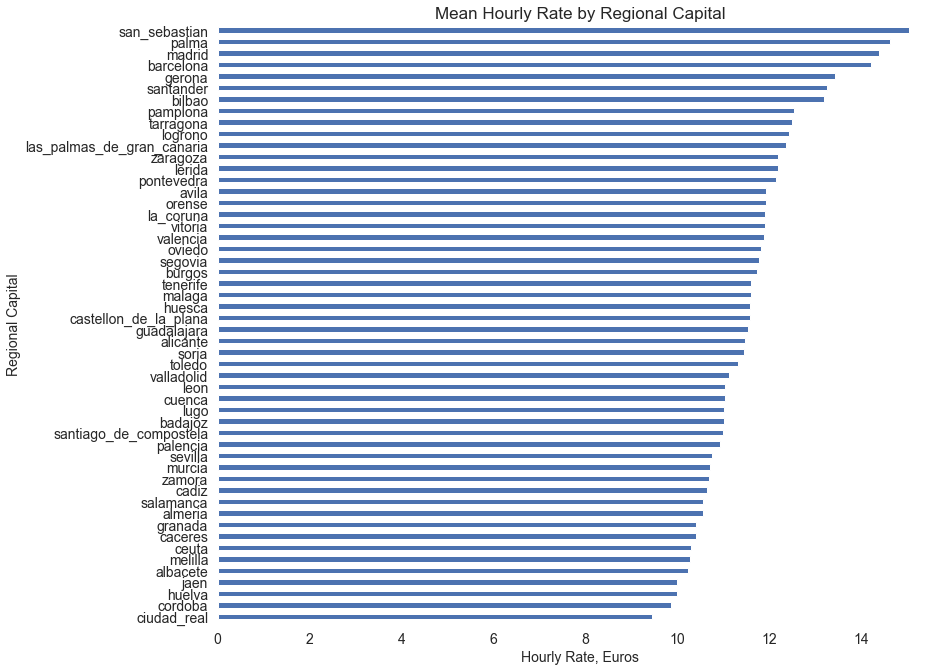

In [361]:

column_grouped_on = 'base_region'
chart_title ="Mean Hourly Rate by Regional Capital"
y_label='Regional Capital' 
summary_stats_chart_price(scraped_profiles_complete_teacher, column_grouped_on, chart_title, y_label )

Lot's of regions.  Let's look at the top X # of regions by teacher count and bucket the rest into "other"


                      mean_price  median_price  min_price  max_price
autonomous_community                                                
balears               14.629518   15.0          6.0        40.0     
madrid                14.383619   15.0          6.0        50.0     
cataluna              14.053297   13.0          6.0        50.0     
cantabria             13.261803   13.0          6.0        25.0     
pais_vasco            13.179504   12.0          6.0        40.0     
navarra               12.532967   12.0          6.0        27.0     
la_rioja              12.425676   12.0          6.0        35.0     
aragon                12.170710   12.0          6.0        30.0     
canarias              12.047436   12.0          5.0        50.0     
galicia               11.960912   12.0          6.0        40.0     
asturias              11.839286   12.0          6.0        25.0     
valencia              11.763942   12.0          6.0        50.0     
castilla_y_leon       11.040984   

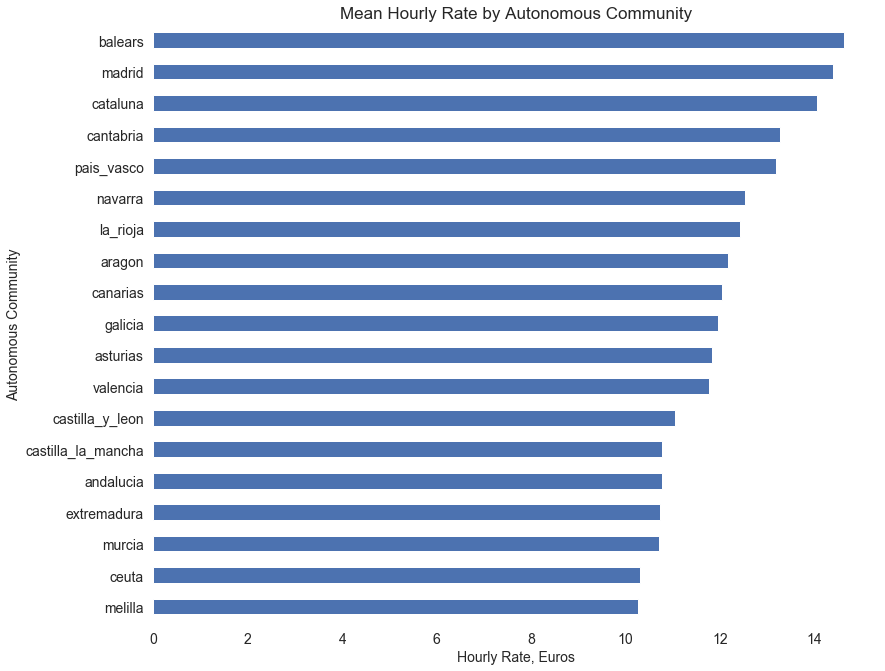

In [362]:
column_grouped_on = 'autonomous_community'
chart_title ="Mean Hourly Rate by Autonomous Community"
y_label='Autonomous Community' 
summary_stats_chart_price(scraped_profiles_complete_teacher, column_grouped_on, chart_title, y_label )



                 mean_price  median_price  min_price  max_price
region_bucket                                                  
madrid           14.383619   15.0          6.0        50.0     
cataluna         14.053297   13.0          6.0        50.0     
pais_vasco       13.179504   12.0          6.0        40.0     
long tail        11.783230   11.5          5.0        50.0     
valencia         11.763942   12.0          6.0        50.0     
castilla_y_leon  11.040984   10.0          6.0        30.0     
andalucia        10.762607   10.0          5.0        40.0     


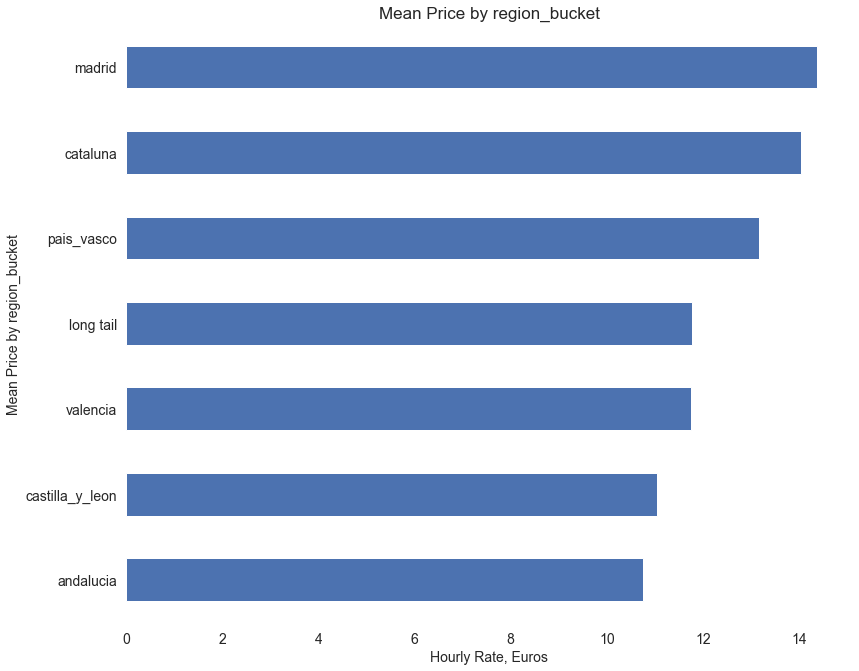

In [371]:
column_grouped_on = 'region_bucket'
chart_title ="Mean Price by region_bucket"
y_label='Mean Price by region_bucket'
summary_stats_chart_price(scraped_profiles_complete_teacher, column_grouped_on, chart_title, y_label)

# Additional Data cuts
Cut data by male / female,  region, has reviews / no reviews, presence of picture/profile, paid advertising / unpaid advertising, native / non-native,

        mean_price  median_price  min_price  max_price
gender                                                
male    15.113455   15.0          6.0        35.0     
female  14.530801   15.0          6.0        50.0     


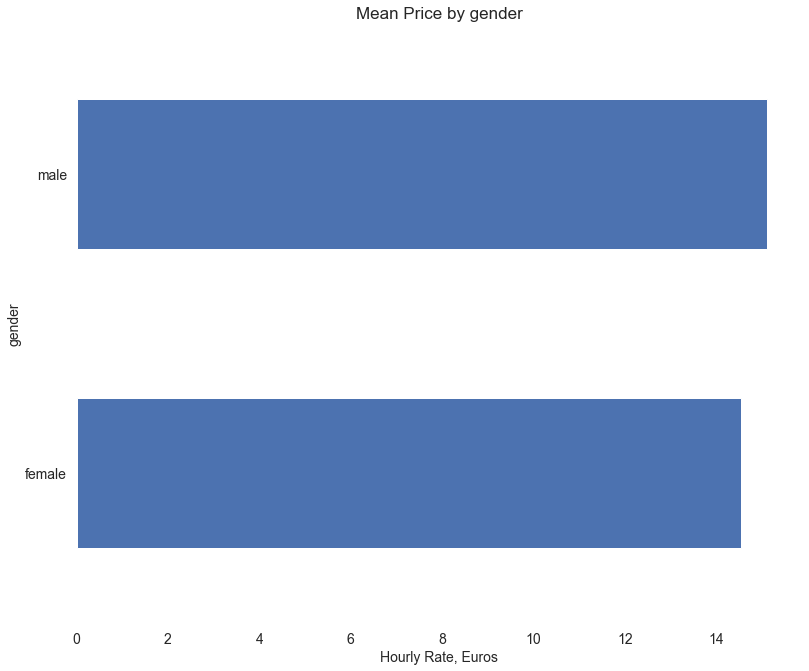

In [388]:
column_grouped_on = 'gender'
chart_title ="Mean Price by gender"
y_label = 'gender'
summary_stats_chart_price(scraped_profiles_complete_teacher, column_grouped_on, chart_title, y_label)


1
gender
2
has_rating
3
advertising_results_boost
4
is_native


Text(0.5, 0.98, 'Variation in Hourly Rate by Specified Categories')

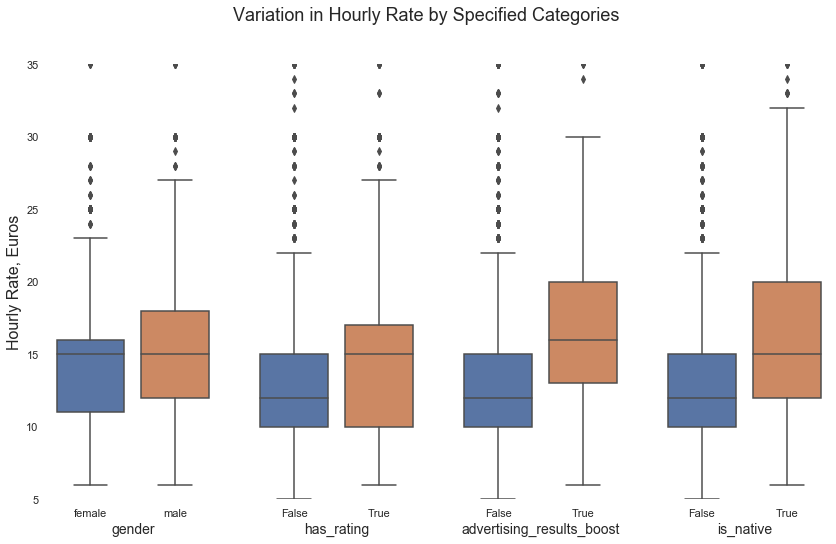

In [489]:
#create 4 subplots - looking at hourly rate differences within 4 different categories: 
#gender, existence of ratings, paid advertising, native/non-native
fig = plt.figure(figsize=(14,8))

category_list=['gender', 'has_rating', 'advertising_results_boost', 'is_native']
n = 1
for category in category_list:
    print(n)
    print(category)
    ax = plt.subplot(1, 4, n)
    ax = sns.boxplot(x=category, y="class_price", data=scraped_profiles_complete_teacher)
    plt.ylabel('Hourly Rate, Euros', fontsize=16)
    ax.set_ylim([5,35])
    plt.xlabel(category, fontsize=14)
    plt.grid(False)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    if n>1:
        ax.yaxis.set_visible(False)
    n += 1

fig.suptitle('Variation in Hourly Rate by Specified Categories', fontsize=18)



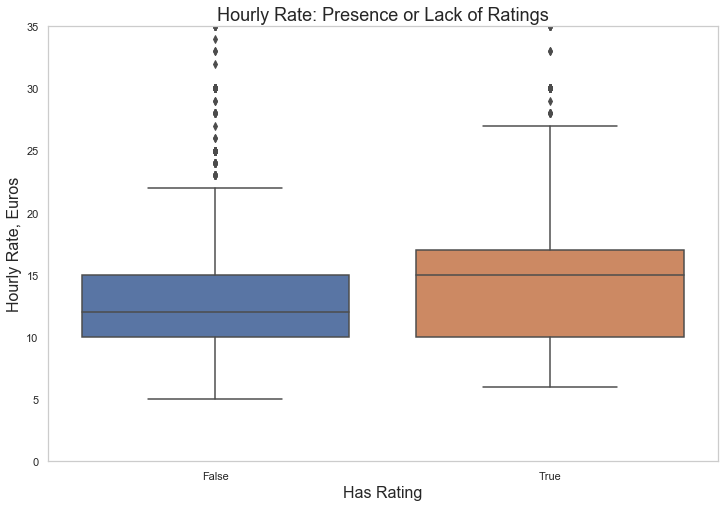

In [418]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="has_rating", y="class_price", data=scraped_profiles_complete_teacher)
ax.set_ylim([0,35])

plt.title('Hourly Rate: Presence or Lack of Ratings', fontsize=18)
plt.xlabel('Has Rating', fontsize=16)
plt.ylabel('Hourly Rate, Euros', fontsize=16)

chart.set_xlim(0,35)

sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)

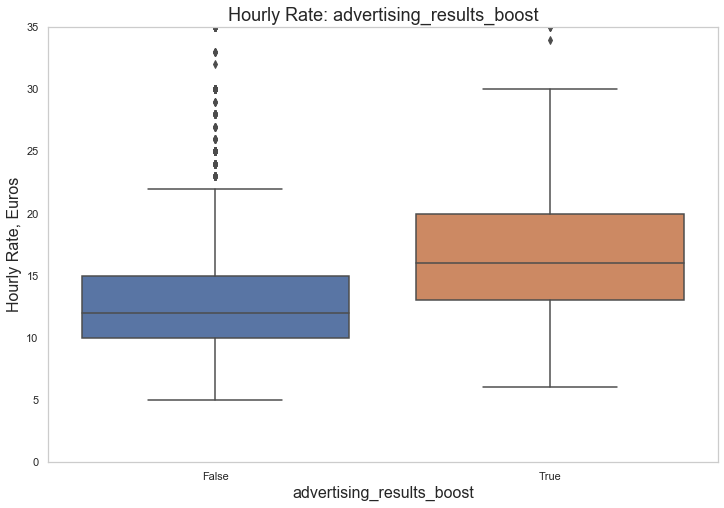

In [419]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="advertising_results_boost", y="class_price", data=scraped_profiles_complete_teacher)
ax.set_ylim([0,35])

plt.title('Hourly Rate: advertising_results_boost', fontsize=18)
plt.xlabel('advertising_results_boost', fontsize=16)
plt.ylabel('Hourly Rate, Euros', fontsize=16)
# figure size in inches




chart.set_xlim(0,35)

sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)

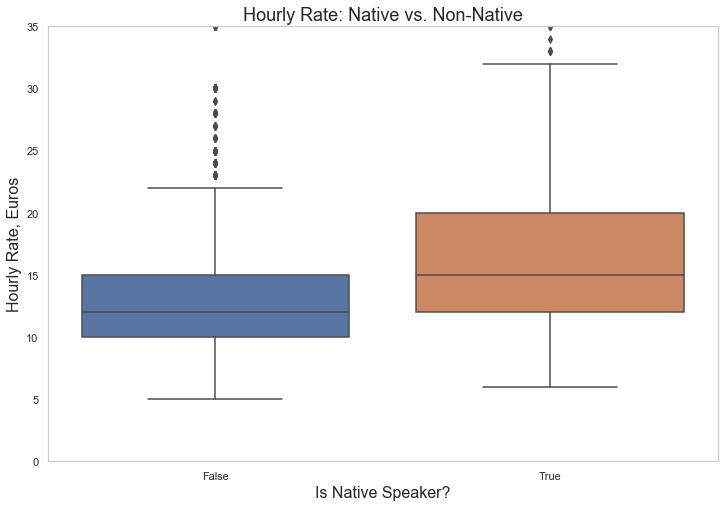

In [437]:
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="is_native", y="class_price", data=scraped_profiles_complete_teacher)
ax.set_ylim([0,35])

plt.title('Hourly Rate: Native vs. Non-Native', fontsize=18)
plt.xlabel('Is Native Speaker?', fontsize=16)
plt.ylabel('Hourly Rate, Euros', fontsize=16)
# figure size in inches




chart.set_xlim(0,35)

sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)

Not a large difference in price of class between males vs. females.

            mean_price  median_price  min_price  max_price
has_rating                                                
True        14.489397   15.0          6.0        50.0     
False       12.107458   12.0          5.0        50.0     


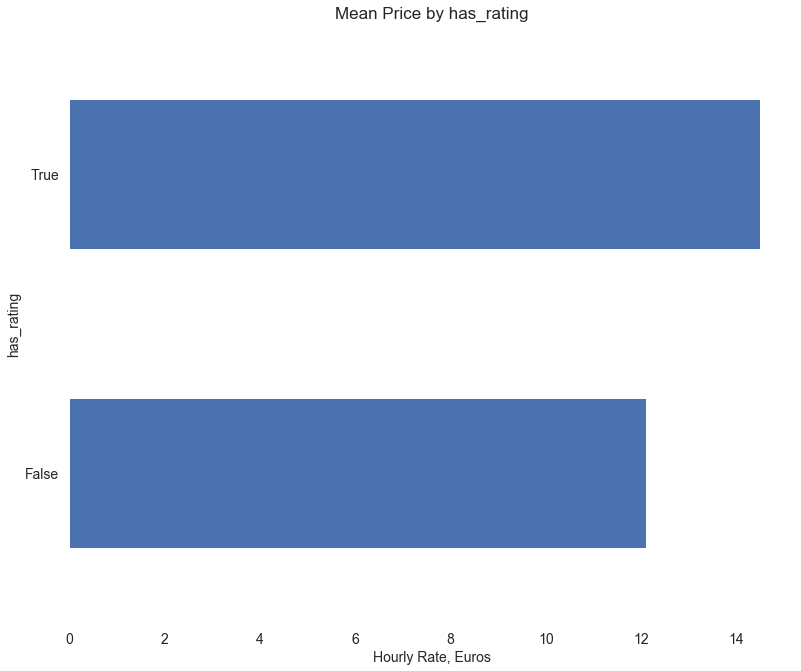

In [389]:
column_grouped_on = 'has_rating'
chart_title ="Mean Price by has_rating"
y_label = 'has_rating'
summary_stats_chart_price(scraped_profiles_complete_teacher, column_grouped_on, chart_title, y_label)


14.5 vs. 12.2 advantage for having ratings. 

# CORRELATION EXPLORATION
Correlation refresheer.  The strength of the relationship varies in degree based on the value of the correlation coefficient. For example, a value of 0.2 shows there is a positive correlation between two variables, but it is weak and likely insignificant. Experts do not consider correlations significant until the value surpasses at least 0.8. However, a correlation coefficient with an absolute value of 0.9 or greater would represent a very strong relationship.


(2.0, 0.0)

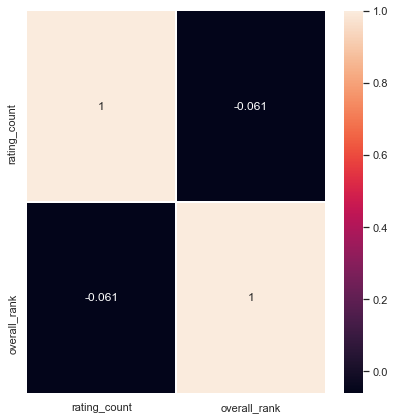

In [649]:
#plt.scatter( scraped_profiles_complete_teacher[rating_mask]['rating_count'], scraped_profiles_complete_teacher[rating_mask]['class_price'])
corrMatrix = scraped_profiles_complete_teacher[['rating_count', 'overall_rank']].corr()
fig, ax = plt.subplots(figsize=(6,6))         
ax.figure.tight_layout()
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


(9.0, 0.0)

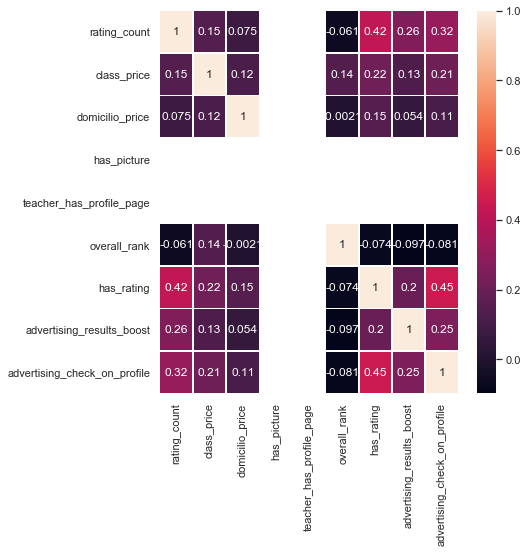

In [438]:
#CORRELATION
columns=['rating_count', 'class_price', 'domicilio_price', 'has_picture', 'teacher_has_profile_page', 'overall_rank', 'has_rating', 'first_class_free', 'advertising_results_boost', 'advertising_check_on_profile', 'is_native']
corrMatrix = scraped_profiles_complete_teacher[columns].corr()
fig, ax = plt.subplots(figsize=(6,6))         
ax.figure.tight_layout()
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


Not seeing a lot of correlations here.  

* Suprising that class price doesn't go up with increased ratings, profile_picture, or has_profile_page. 
* Algorithm for results ranking clearly does not take into account # ratings, presence of picture/profile page

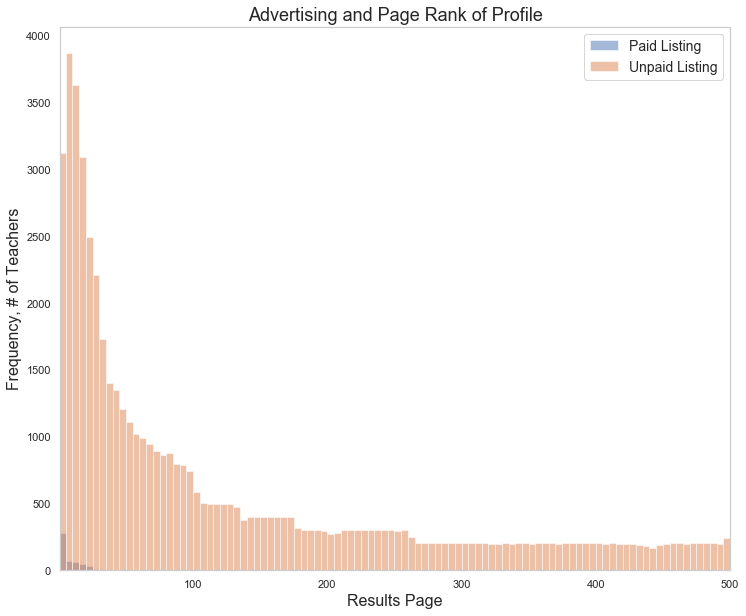

In [592]:
fig, ax= plt.subplots(figsize=(12, 10))
bins =100
ax.hist(scraped_profiles_complete_teacher['results_page_pagination_number'][scraped_profiles_complete_teacher['advertising_results_boost']==True], bins, alpha=0.5, range=[0,500] , label='Paid Listing')
ax.hist(scraped_profiles_filtered['results_page_pagination_number'][scraped_profiles_filtered['advertising_results_boost']==False], bins, alpha=0.5, range=[0,500], label='Unpaid Listing')
ax.legend(loc='upper right')
ax.legend(fontsize=14)
plt.title('Advertising and Page Rank of Profile', fontsize=18)
plt.xlabel('Results Page', fontsize=16)
plt.ylabel('Frequency, # of Teachers', fontsize=16)
ax.set_xlim(1,500)
sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)

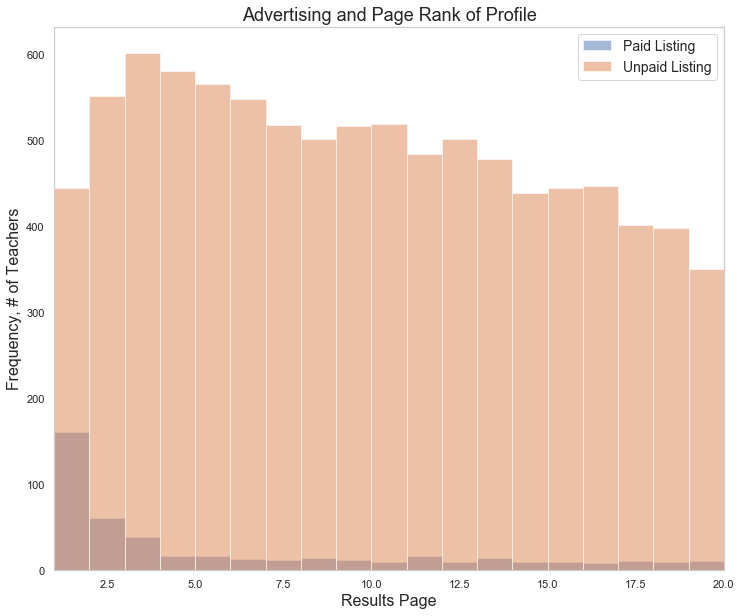

In [593]:
fig, ax= plt.subplots(figsize=(12, 10))
bins =500
ax.hist(scraped_profiles_complete_teacher['results_page_pagination_number'][scraped_profiles_complete_teacher['advertising_results_boost']==True], bins, alpha=0.5, range=[0,500] , label='Paid Listing')
ax.hist(scraped_profiles_complete_teacher['results_page_pagination_number'][scraped_profiles_complete_teacher['advertising_results_boost'] == False], bins, alpha=0.5, range=[0,500], label='Unpaid Listing')
ax.legend(loc='upper right')
ax.legend(fontsize=14)
plt.title('Advertising and Page Rank of Profile', fontsize=18)
plt.xlabel('Results Page', fontsize=16)
plt.ylabel('Frequency, # of Teachers', fontsize=16)
ax.set_xlim(1,20)
sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)

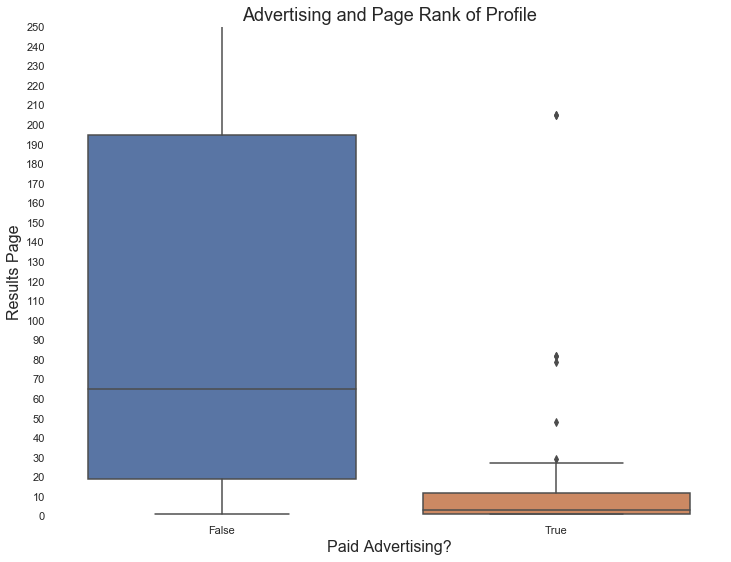

In [660]:
import matplotlib.ticker as ticker

plt.figure(figsize=(12,9))
ax = sns.boxplot(x="advertising_results_boost", y="results_page_pagination_number", data=scraped_profiles_complete_teacher)
ax.set_ylim([0,250])
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.title('Advertising and Page Rank of Profile', fontsize=18)
plt.xlabel('Paid Advertising?', fontsize=16)
plt.ylabel('Results Page', fontsize=16)
for key, spine in ax.spines.items():
    spine.set_visible(False)
plt.grid(False)

In [595]:
#look only at first page - how many are paid vs. unpaid?
page_one_mask = scraped_profiles_complete_teacher.results_page_pagination_number==1

print('PAID_ADVERTISING % of profiles for all results')
print(scraped_profiles_complete_teacher.advertising_results_boost.value_counts(normalize=True)*100)

print('PAID_ADVERTISING % of profiles for FIRST PAGE RESULTS')
print(scraped_profiles_complete_teacher[page_one_mask].advertising_results_boost.value_counts(normalize=True)*100)

PAID_ADVERTISING % of profiles for all results
False    98.655575
True     1.344425 
Name: advertising_results_boost, dtype: float64
PAID_ADVERTISING % of profiles for FIRST PAGE RESULTS
False    73.38843
True     26.61157
Name: advertising_results_boost, dtype: float64


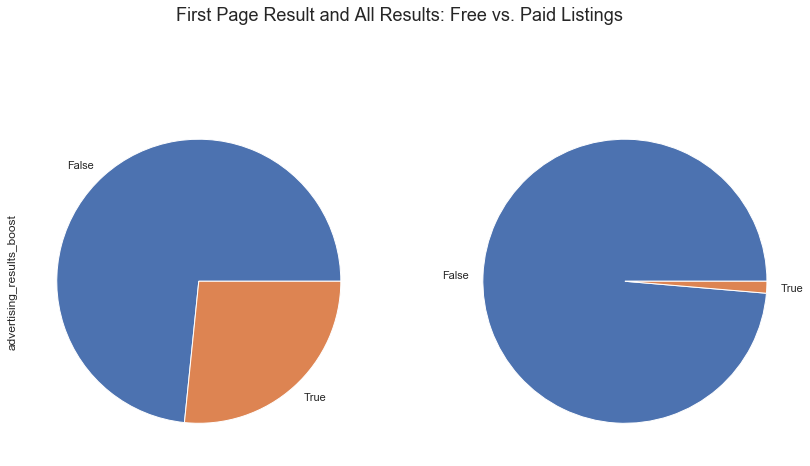

In [618]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 15.0

fig = plt.figure(figsize=(14,8))
ax = plt.subplot(1, 2, 1)
ax = scraped_profiles_complete_teacher[page_one_mask].advertising_results_boost.value_counts(normalize=True).plot(kind='pie', title='biddiez',  subplots=True, figsize=(10, 8))
ax = plt.subplot(1, 2, 2)
ax = scraped_profiles_complete_teacher.advertising_results_boost.value_counts(normalize=True).plot(kind='pie',  subplots=True, figsize=(10, 8))
fig.suptitle('First Page Result and All Results: Free vs. Paid Listings', fontsize=18)
plt.axis('off')
plt.show()

1
gender
2
has_rating
3
advertising_results_boost
4
is_native


Text(0.5, 0.98, 'Variation in Hourly Rate by Specified Categories')

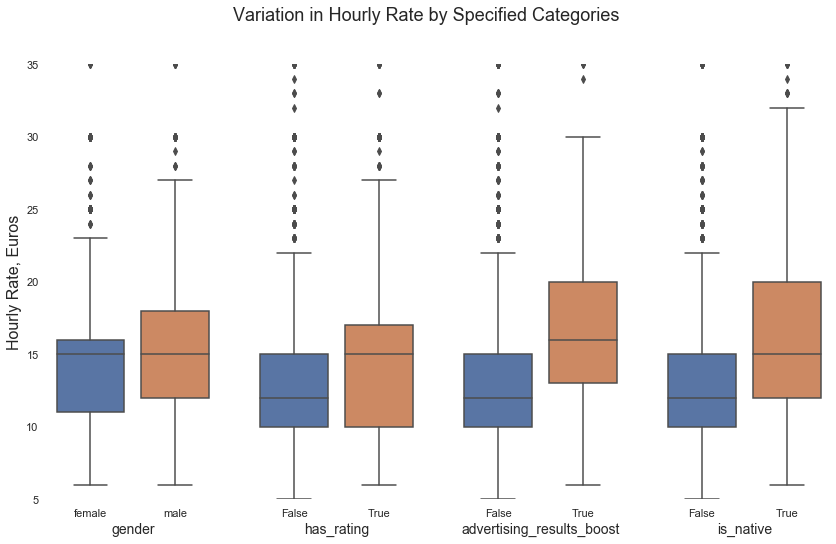

In [661]:
fig = plt.figure(figsize=(14,8))

category_list=['gender', 'has_rating', 'advertising_results_boost', 'is_native']
n = 1
for category in category_list:
    print(n)
    print(category)
    ax = plt.subplot(1, 4, n)
    ax = sns.boxplot(x=category, y="class_price", data=scraped_profiles_complete_teacher)
    plt.ylabel('Hourly Rate, Euros', fontsize=16)
    ax.set_ylim([5,35])
    plt.xlabel(category, fontsize=14)
    plt.grid(False)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    if n>1:
        ax.yaxis.set_visible(False)
    n += 1

fig.suptitle('Variation in Hourly Rate by Specified Categories', fontsize=18)


1
teacher_has_profile_page
2
has_picture
3
has_price
4
has_rating


Text(0.5, 0.98, 'Variation in Results Page by Specified Categories')

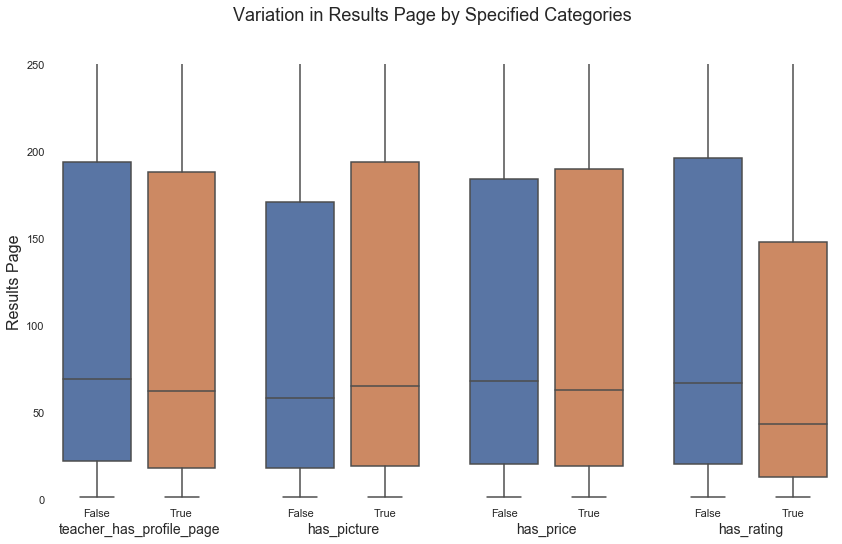

In [667]:
fig = plt.figure(figsize=(14,8))

category_list= ['teacher_has_profile_page', 'has_picture', 'has_price', 'has_rating']
n = 1
for category in category_list:
    print(n)
    print(category)
    ax = plt.subplot(1, 4, n)
    ax = sns.boxplot(x=category, y="results_page_pagination_number", data=scraped_profiles_filtered)
    #ax = sns.swarmplot(x=category, y="results_page_pagination_number", data=scraped_profiles_filtered, color="grey")
    plt.ylabel('Results Page', fontsize=16)
    ax.set_ylim([0,250])
    plt.xlabel(category, fontsize=14)
    plt.grid(False)
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    if n>1:
        ax.yaxis.set_visible(False)
    n += 1

fig.suptitle('Variation in Results Page by Specified Categories', fontsize=18)

(0, 450)

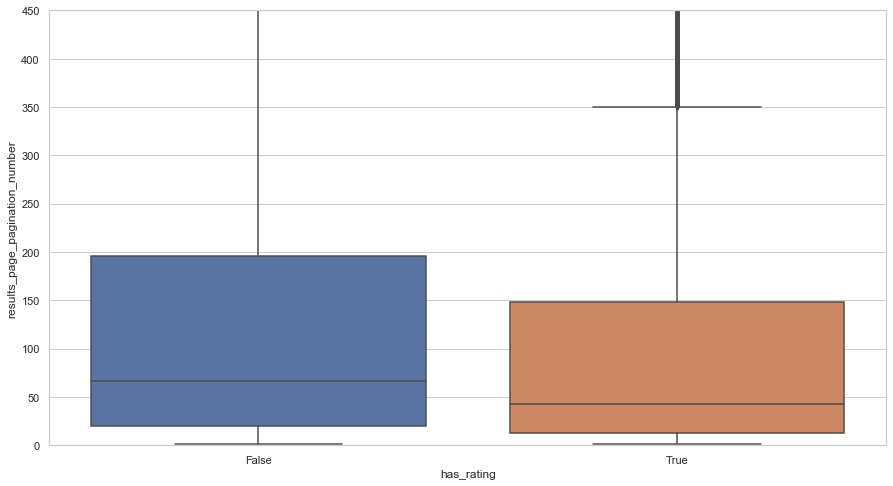

In [625]:
#todo - plot these 3-4 variables on subplot - basically shows that they don't make a difference in ranking
columns= ['teacher_has_profile_page', 'has_picture', 'has_price', 'complete_teacher' ]
scraped_profiles_filtered
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="has_rating", y="results_page_pagination_number", data=scraped_profiles_filtered)
ax.set_ylim([0,450])

In [ ]:
fig, ax= plt.subplots(figsize=(12, 10))
bins =500
ax.hist(scraped_profiles_complete_teacher['results_page_pagination_number'][scraped_profiles_complete_teacher['advertising_results_boost']], bins, alpha=0.5, range=[0,500] , label='Paid Listing')
ax.hist(scraped_profiles_complete_teacher['results_page_pagination_number'][scraped_profiles_complete_teacher['advertising_results_boost'] == False], bins, alpha=0.5, range=[0,500], label='Unpaid Listing')
ax.legend(loc='upper right')
ax.legend(fontsize=14)
plt.title('Advertising and Page Rank of Profile', fontsize=18)
plt.xlabel('Results Page', fontsize=16)
plt.ylabel('Frequency, # of Teachers', fontsize=16)
ax.set_xlim(1,20)
sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)

Ok. CLEARLY shows that purchasing advertising results in a better placement on the page.  Good.

# reviews vs. price

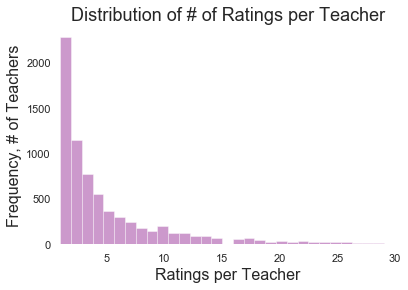

In [670]:
rating_mask= scraped_profiles_complete_teacher.has_rating==True
chart = sns.distplot(scraped_profiles_complete_teacher[rating_mask]['rating_count'], kde=False, color='purple', bins=400)
plt.title('Distribution of # of Ratings per Teacher', fontsize=18)
plt.xlabel('Ratings per Teacher', fontsize=16)
plt.ylabel('Frequency, # of Teachers', fontsize=16)
chart.set_xlim(1,30)
sns.set(style="whitegrid")
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)

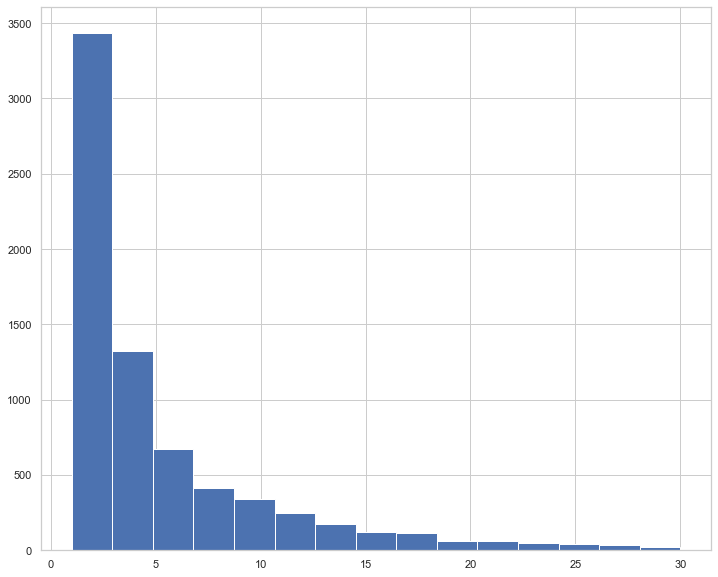

In [495]:
fig, ax= plt.subplots(figsize=(12, 10))
ax.hist(scraped_profiles_complete_teacher[rating_mask]['rating_count'], range=(1,30), bins=15)
plt.show()

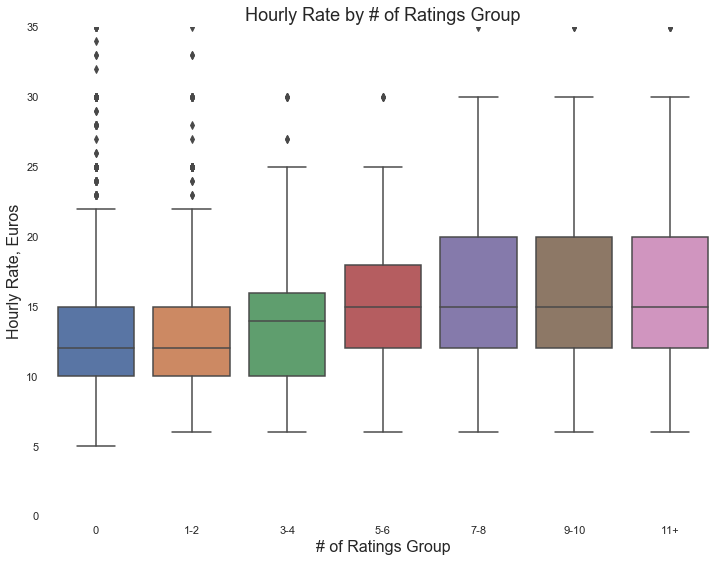

In [524]:
plt.figure(figsize=(12,9))
ax = sns.boxplot(x="rating_bin", y="class_price", data=scraped_profiles_complete_teacher)
ax.set_ylim([0,35])
plt.title('Hourly Rate by # of Ratings Group', fontsize=18)
plt.xlabel('# of Ratings Group', fontsize=16)
plt.ylabel('Hourly Rate, Euros', fontsize=16)
for key, spine in ax.spines.items():
    spine.set_visible(False)
plt.grid(False)



Teachers start charging more once they have more than 2 reviews.  At 7 or more reviews, the asking price levels out.  Suspicious that the last 3 groups are identical.

            mean_price  median_price  min_price  max_price
rating_bin                                                
11+         16.320856   15.0          6.0        40.0     
7-8         15.882212   15.0          6.0        40.0     
9-10        15.701754   15.0          6.0        40.0     
5-6         14.943452   15.0          6.0        50.0     
3-4         14.175758   14.0          6.0        30.0     
1-2         13.633983   12.0          6.0        47.0     
0           12.107458   12.0          5.0        50.0     


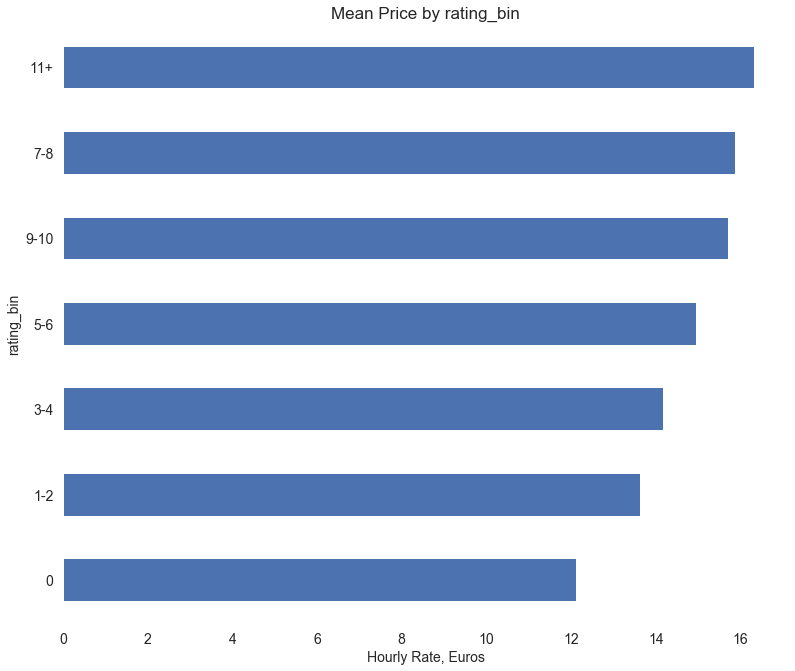

In [410]:
#get summary stats of class_price by rating_bin
column_grouped_on = 'rating_bin'
chart_title ="Mean Price by rating_bin"
y_label = 'rating_bin'
summary_stats_chart_price(scraped_profiles_complete_teacher, column_grouped_on, chart_title, y_label)


Some observations:
* As ratings increase, teachers charge more.  Both boxplot and horizontal bar chart of mean price support this.  High rating buckets have almost identical price distributions (using median - using mean, relationship is slightly positive correlation)
* Teachers should charge more as ratings increase!  But not a lot more.  